############################################################
### BÖLÜM 0: KURULUM VE VERİ YÜKLEME BAŞLADI ###
############################################################

--- Ham veri setinin ilk durumu ---
Veri Seti Boyutu: (7728394, 46)

--- Veri Seti Bilgisi (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Columns: 46 entries, ID to Astronomical_Twilight
dtypes: bool(13), float64(12), int64(1), object(20)
memory usage: 10.6 GB



############################################################
### BÖLÜM 1: ÖRNEKLEME VE VERİ SETLERİNİ AYIRMA BAŞLADI ###
############################################################

--- 500,000 satırlık rastgele bir örneklem alınıyor... ---
--- Veri, Eğitim ve Test Setlerine Bölünüyor (Veri Sızıntısını Önlemek İçin EN BAŞTA YAPILIR!) ---
Eğitim seti boyutu (X_train): (5600000, 45)
Test seti boyutu (X_test): (1400000, 45)

--- Eğitim Setindeki Sınıf Dağılımı (Dengesizliği Görmek İçin) ---
Severity
2    0.79661

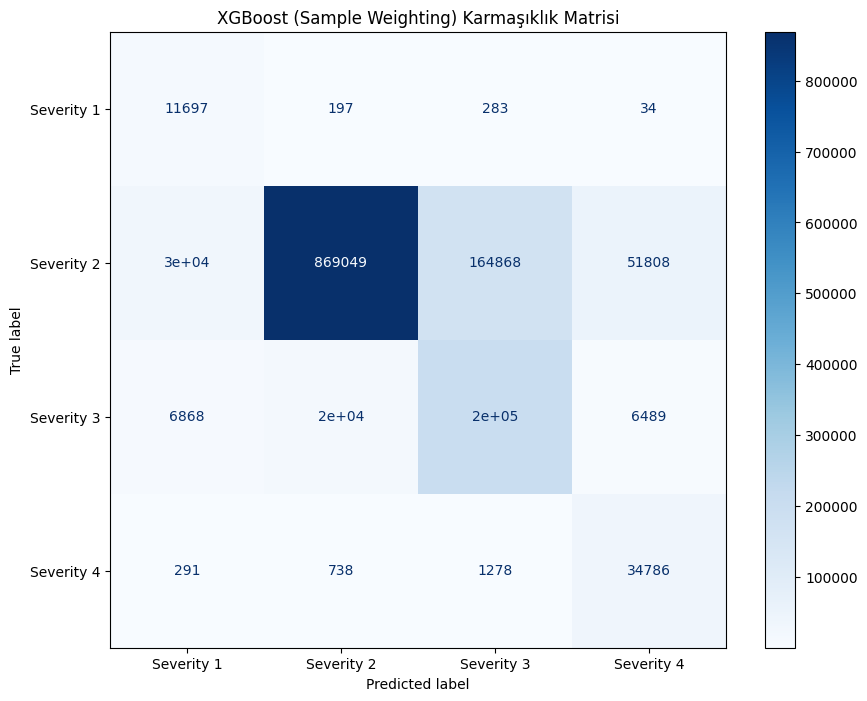




############################################################
### BÖLÜM 8: ÖZELLİK ÖNEMİ ANALİZİ BAŞLADI ###
############################################################


--- En Önemli 20 Özellik ---
                    feature  importance
26      FEAT_Is_Road_Closed    0.170195
28         FEAT_Is_Slowdown    0.140078
31                 State_AZ    0.100355
29            FEAT_Is_Crash    0.090433
27     FEAT_Is_Lane_Blocked    0.049897
2              Distance(mi)    0.034129
69                 State_TN    0.029739
19           Traffic_Signal    0.029570
24            Duration(min)    0.021044
47                 State_MD    0.019065
111  Road_Type_Local_Street    0.018454
25        Is_Low_Speed_Zone    0.017259
54                 State_NC    0.017193
10                 Crossing    0.011619
37                 State_FL    0.011537
32                 State_CA    0.010865
5              Pressure(in)    0.009435
70                 State_TX    0.008583
22               Is_Weekend    0.0082

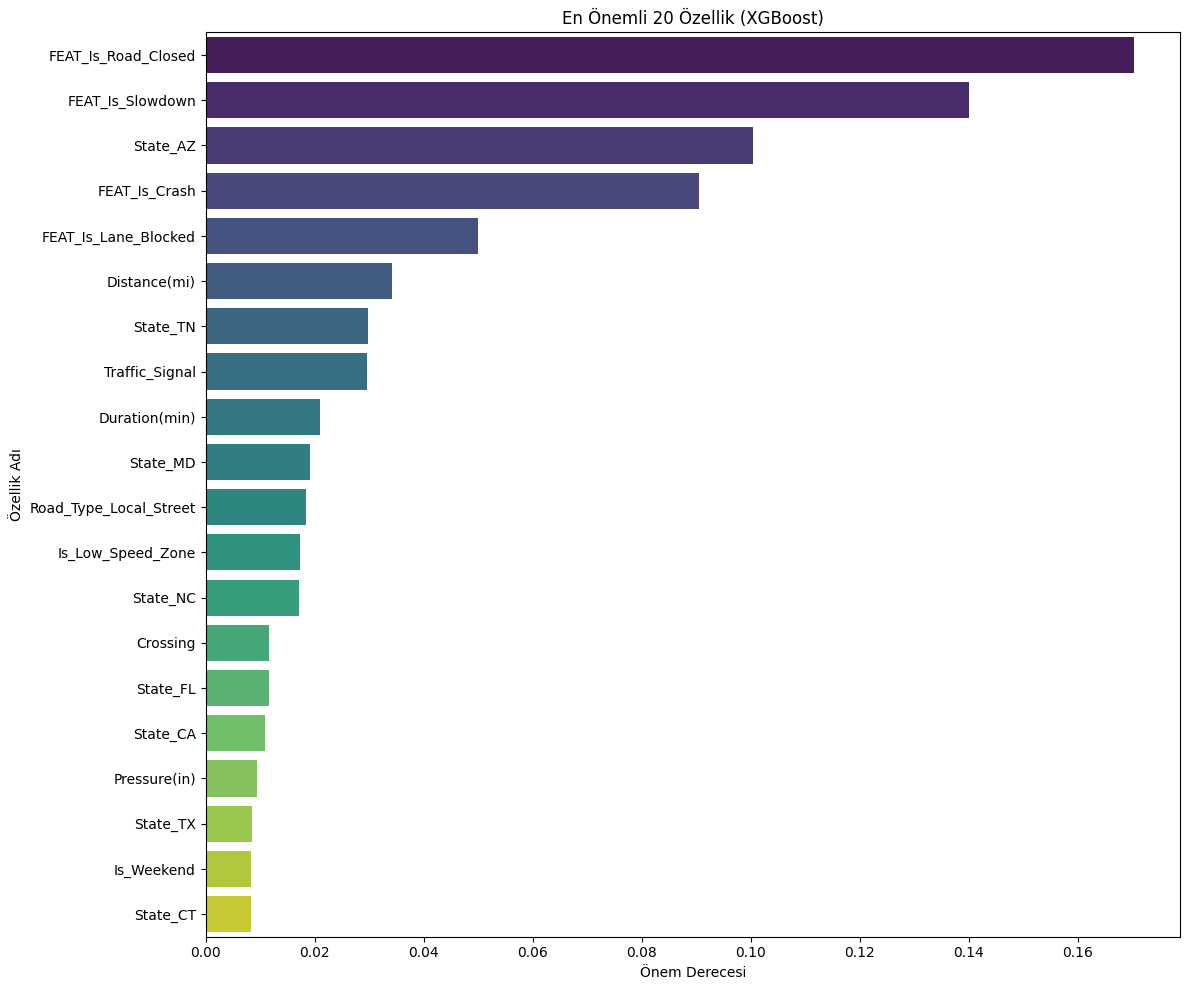



############################################################
### TÜM SÜREÇ TAMAMLANDI! ###
############################################################


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Gerekli modelleme ve metrik kütüphaneleri
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_sample_weight
import time

# ======================================================================================
# --- BÖLÜM 0: KURULUM VE VERİ YÜKLEME ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 0: KURULUM VE VERİ YÜKLEME BAŞLADI ###")
print("############################################################\n")

df = pd.read_csv('US_Accidents_March23.csv') 
print("--- Ham veri setinin ilk durumu ---")
print(f"Veri Seti Boyutu: {df.shape}")
print("\n--- Veri Seti Bilgisi (df.info()) ---")
df.info(verbose=False, memory_usage='deep')
print("\n\n")


# ======================================================================================
# --- BÖLÜM 1: ÖRNEKLEME VE VERİ SETLERİNİ AYIRMA ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 1: ÖRNEKLEME VE VERİ SETLERİNİ AYIRMA BAŞLADI ###")
print("############################################################\n")

print("--- 500,000 satırlık rastgele bir örneklem alınıyor... ---")
df_sample = df.sample(n=7000000, random_state=42)
del df

print("--- Veri, Eğitim ve Test Setlerine Bölünüyor (Veri Sızıntısını Önlemek İçin EN BAŞTA YAPILIR!) ---")
X = df_sample.drop('Severity', axis=1)
y = df_sample['Severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Eğitim seti boyutu (X_train): {X_train.shape}")
print(f"Test seti boyutu (X_test): {X_test.shape}")
print("\n--- Eğitim Setindeki Sınıf Dağılımı (Dengesizliği Görmek İçin) ---")
print(y_train.value_counts(normalize=True))
print("\n\n")


# ======================================================================================
# --- BÖLÜM 2: ÖZELLİK YARATMA (FEATURE CREATION) ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 2: ÖZELLİK YARATMA BAŞLADI ###")
print("############################################################\n")

def feature_creation_pipeline(df_input):
    df = df_input.copy()
    
    # --- 2A: Zamansal Özellikler ---
    print("... Zamansal özellikler oluşturuluyor...")
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')
    df['Hour'] = df['Start_Time'].dt.hour
    df['DayOfWeek'] = df['Start_Time'].dt.day_name()
    df['Is_Weekend'] = df['DayOfWeek'].isin(['Saturday', 'Sunday'])
    # DİKKAT: İsteğiniz üzerine, Rush Hour sadece hafta içi günlerde geçerli olacak şekilde ayarlandı.
    df['Is_Rush_Hour'] = (~df['Is_Weekend']) & (df['Hour'].isin([7, 8, 9, 15, 16, 17, 18]))
    df['Duration(min)'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60
    df.loc[df['Duration(min)'] < 0, 'Duration(min)'] = 0

    # --- 2B: 'Street' Sütunundan Anlam Çıkarma ---
    # Yorum: 'Street' sütununda 300 binden fazla eşsiz değer var. Bunu doğrudan One-Hot-Encode yapmak
    # binlerce yeni sütun yaratır ve modeli mahveder. Bunun yerine, içinden anlamlı bilgiler türetiyoruz.
    print("... 'Street' sütunundan Road_Type ve Is_Low_Speed_Zone özellikleri türetiliyor...")
    if 'Street' in df.columns:
        df['Street'].fillna('Unknown', inplace=True)
        highway_keywords = ['Hwy', 'Fwy', 'Pkwy', 'Expy', 'Blvd', 'Highway', 'Freeway', 'I-', 'US-']
        df['Road_Type'] = df['Street'].apply(lambda x: 'Highway/Main_Road' if any(kw in str(x) for kw in highway_keywords) else 'Local_Street')
        low_speed_keywords = ['St', 'Dr', 'Ave', 'Rd', 'Ln', 'Ct', 'Pl']
        pattern = r'\b(' + '|'.join(low_speed_keywords) + r')\b'
        df['Is_Low_Speed_Zone'] = df['Street'].str.contains(pattern, case=False, na=False)

    # --- 2C: 'Description' Sütunundan Metin Madenciliği ---
    print("... 'Description' sütunundan metin bazlı özellikler kazınıyor...")
    if 'Description' in df.columns:
        desc_lower = df['Description'].str.lower().fillna('')
        df['FEAT_Is_Road_Closed'] = desc_lower.str.contains('closed|closure', na=False)
        df['FEAT_Is_Lane_Blocked'] = desc_lower.str.contains('blocked|lane', na=False)
        df['FEAT_Is_Slowdown'] = desc_lower.str.contains('traffic|slow|caution', na=False)
        df['FEAT_Is_Crash'] = desc_lower.str.contains('crash', na=False)
        
    return df

X_train_created = feature_creation_pipeline(X_train)
X_test_created = feature_creation_pipeline(X_test)

print("\n--- Eğitim Seti (X_train_created) Özellik Yaratma Sonrası Durum ---")
print(f"Boyut: {X_train_created.shape}")
print(f"Toplam Eksik Veri: {X_train_created.isnull().sum().sum()}")
print("--- Sütun Tipleri (df.info()) ---")
X_train_created.info(verbose=False)
print("\n\n")


# ======================================================================================
# --- BÖLÜM 3: ÖZELLİK SEÇİMİ (FEATURE SELECTION) ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 3: ÖZELLİK SEÇİMİ VE TEMİZLEME BAŞLADI ###")
print("############################################################\n")

# İsteğiniz üzerine, tüm hava durumu sütunları dahil, gereksiz görülen her şey kaldırılıyor.
cols_to_drop = [
    'ID', 'Source', 'End_Lat', 'End_Lng', 'County', 'Zipcode', 'Country', 
    'Start_Time', 'End_Time', 'Timezone', 'Airport_Code', 
    # İşlenip bilgisi aktarılanlar
    'Street', 'Description', 
    # Hava durumu ile ilgili her şey
    'Weather_Timestamp', 'Wind_Chill(F)', 'Precipitation(in)', 'Weather_Condition'
]
print(f"--- Silinecek {len(cols_to_drop)} sütun var. ---")
X_train_selected = X_train_created.drop(columns=cols_to_drop, errors='ignore')
X_test_selected = X_test_created.drop(columns=cols_to_drop, errors='ignore')

print("\n--- Eğitim Seti (X_train_selected) Özellik Seçimi Sonrası Durum ---")
print(f"Boyut: {X_train_selected.shape}")
print(f"Toplam Eksik Veri: {X_train_selected.isnull().sum().sum()}")
print("--- Sütun Tipleri (df.info()) ---")
X_train_selected.info(verbose=False)
print("\n\n")


# ======================================================================================
# --- BÖLÜM 4: VERİ TEMİZLEME (IMPUTATION VE OUTLIER) ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 4: VERİ TEMİZLEME BAŞLADI ###")
print("############################################################\n")

# --- 4A: Akıllı Doldurma ve 'City' Sütununu Silme ---
print("... Şehir bazlı medyan ile sıcaklık dolduruluyor...")
city_median_temps_map = X_train_selected.groupby('City')['Temperature(F)'].median()
X_train_imputed = X_train_selected.copy()
X_test_imputed = X_test_selected.copy()
X_train_imputed['Temperature(F)'].fillna(X_train_imputed['City'].map(city_median_temps_map), inplace=True)
X_test_imputed['Temperature(F)'].fillna(X_test_imputed['City'].map(city_median_temps_map), inplace=True)
X_train_imputed.drop(columns=['City'], inplace=True)
X_test_imputed.drop(columns=['City'], inplace=True)

# --- 4B: Aykırı Değer Yönetimi (Clipping) ---
print("... Aykırı değerler temizleniyor (Clipping)...")
cols_to_clip = [col for col in ['Temperature(F)', 'Wind_Speed(mph)', 'Distance(mi)', 'Duration(min)', 'Pressure(in)', 'Humidity(%)', 'Visibility(mi)'] if col in X_train_imputed.columns]
for col in cols_to_clip:
    lower, upper = X_train_imputed[col].quantile(0.01), X_train_imputed[col].quantile(0.99)
    X_train_imputed[col] = X_train_imputed[col].clip(lower=lower, upper=upper)
    X_test_imputed[col] = X_test_imputed[col].clip(lower=lower, upper=upper)

# --- 4C: Kalan Eksik Verileri Doldurma ---
print("... Kalan tüm eksik veriler dolduruluyor...")
fill_values = {col: (X_train_imputed[col].median() if pd.api.types.is_numeric_dtype(X_train_imputed[col]) else X_train_imputed[col].mode()[0]) for col in X_train_imputed.columns if X_train_imputed[col].isnull().sum() > 0}
X_train_imputed.fillna(value=fill_values, inplace=True)
X_test_imputed.fillna(value=fill_values, inplace=True)

print("\n--- Eğitim Seti (X_train_imputed) Veri Temizleme Sonrası Durum ---")
print(f"Boyut: {X_train_imputed.shape}")
print(f"Toplam Eksik Veri: {X_train_imputed.isnull().sum().sum()}")
print("--- Sütun Tipleri (df.info()) ---")
X_train_imputed.info(verbose=False)
print("\n\n")


# ======================================================================================
# --- BÖLÜM 5: MODELLEME İÇİN SON HAZIRLIK (ENCODING VE SCALING) ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 5: MODELLEME İÇİN SON HAZIRLIK BAŞLADI ###")
print("############################################################\n")

# --- 5A: Kategorik Değişkenlerin Kodlanması (One-Hot Encoding) ---
print("... Kategorik değişkenler sayısala çevriliyor (One-Hot Encoding)...")
categorical_cols = X_train_imputed.select_dtypes(include='object').columns.tolist()
print(f"One-Hot Encoding uygulanacak sütunlar: {categorical_cols}")
X_train_encoded = pd.get_dummies(X_train_imputed, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_imputed, columns=categorical_cols, drop_first=True)
train_cols, test_cols = X_train_encoded.columns, X_test_encoded.columns
missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test: X_test_encoded[c] = False
X_test_encoded = X_test_encoded[train_cols]

# --- 5B: Sayısal Değişkenlerin Ölçeklendirilmesi (Scaling) ---
print("... Sayısal değişkenler ölçeklendiriliyor (StandardScaler)...")
cols_to_scale = [col for col in X_train_imputed.select_dtypes(include=np.number).columns if col in X_train_encoded.columns]
scaler = StandardScaler()
X_train_final = X_train_encoded.copy()
X_test_final = X_test_encoded.copy()
X_train_final[cols_to_scale] = scaler.fit_transform(X_train_encoded[cols_to_scale])
X_test_final[cols_to_scale] = scaler.transform(X_test_encoded[cols_to_scale])

print("\n--- Nihai Eğitim Seti (X_train_final) Durumu ---")
print(f"Boyut: {X_train_final.shape}")
print(f"Toplam Eksik Veri: {X_train_final.isnull().sum().sum()}")
print("Tüm sütunlar artık sayısal veya boolean. Modele hazır.\n\n")


# ======================================================================================
# --- BÖLÜM 6: XGBOOST İLE MODEL EĞİTİMİ (SAĞLAM YÖNTEM) ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 6: XGBOOST MODEL EĞİTİMİ BAŞLADI ###")
print("############################################################\n")

# Yorum: ADASYN'in yarattığı gürültü ve sınıf çakışması probleminden kaçınmak için,
# en sağlam ve güvenilir yöntem olan sınıf ağırlıklandırmaya geri dönüyoruz.
# Bu, modelin azınlık sınıflarına daha fazla önem vermesini sağlar.

# --- 6A: Hedef Değişkeni Ayarlama ---
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1
print(f"Ayarlanmış y_train değerleri: {np.sort(y_train_adjusted.unique())}")

# --- 6B: Sınıf Dengesizliği için Ağırlık Hesaplama ---
print("... Sınıf dengesizliği için örnek ağırlıkları hesaplanıyor...")
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_adjusted)

# --- 6C: XGBoost Modelini Tanımlama ve Eğitme ---
print("... XGBoost modeli tanımlanıyor ve eğitiliyor...")
model = xgb.XGBClassifier(
    objective='multi:softmax', num_class=4, n_estimators=200, max_depth=6,
    learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss',
    random_state=42, n_jobs=-1
)
start_time = time.time()
model.fit(X_train_final, y_train_adjusted, sample_weight=sample_weights)
end_time = time.time()
print(f"\nEğitim süresi: {end_time - start_time:.2f} saniye")
print("\n\n")


# ======================================================================================
# --- BÖLÜM 7: MODEL DEĞERLENDİRMESİ ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 7: MODEL DEĞERLENDİRMESİ BAŞLADI ###")
print("############################################################\n")
y_pred = model.predict(X_test_final)
print("--- Sınıflandırma Raporu (Classification Report) ---")
print(classification_report(y_test_adjusted, y_pred, target_names=['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']))
print("\n--- Karmaşıklık Matrisi (Confusion Matrix) Görselleştiriliyor... ---")
cm = confusion_matrix(y_test_adjusted, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4'])
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('XGBoost (Sample Weighting) Karmaşıklık Matrisi')
plt.show()
print("\n\n")


# ======================================================================================
# --- BÖLÜM 8: ÖZELLİK ÖNEMİ ANALİZİ ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 8: ÖZELLİK ÖNEMİ ANALİZİ BAŞLADI ###")
print("############################################################\n")
feature_importances = pd.DataFrame({
    'feature': X_train_final.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print("\n--- En Önemli 20 Özellik ---")
print(feature_importances.head(20))
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')
plt.title('En Önemli 20 Özellik (XGBoost)')
plt.xlabel('Önem Derecesi')
plt.ylabel('Özellik Adı')
plt.tight_layout()
plt.show()

print("\n\n############################################################")
print("### TÜM SÜREÇ TAMAMLANDI! ###")
print("############################################################")

############################################################
### BÖLÜM 0: KURULUM VE VERİ YÜKLEME BAŞLADI ###
############################################################

--- Ham veri setinin ilk durumu ---
Veri Seti Boyutu: (7728394, 46)

--- Veri Seti Bilgisi (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Columns: 46 entries, ID to Astronomical_Twilight
dtypes: bool(13), float64(12), int64(1), object(20)
memory usage: 9.5 GB



############################################################
### BÖLÜM 1: ÖRNEKLEME VE VERİ SETLERİNİ AYIRMA BAŞLADI ###
############################################################

--- 7,000,000 satırlık rastgele bir örneklem alınıyor... ---
--- Veri, Eğitim ve Test Setlerine Bölünüyor (Veri Sızıntısını Önlemek İçin EN BAŞTA YAPILIR!) ---
Eğitim seti boyutu (X_train): (800000, 45)
Test seti boyutu (X_test): (200000, 45)

--- Eğitim Setindeki Sınıf Dağılımı (Dengesizliği Görmek İçin) ---
Severity
2    0.796174

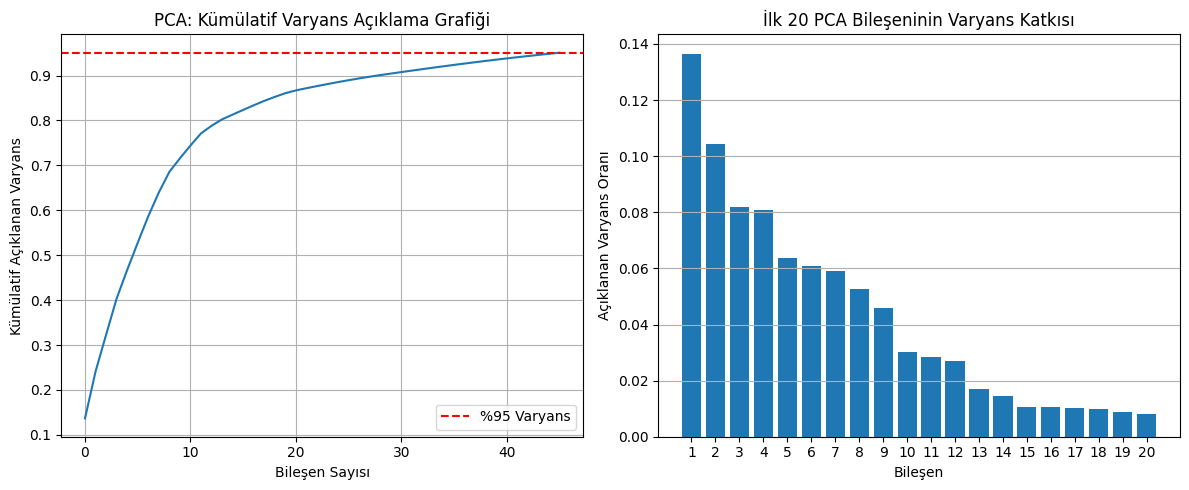




############################################################
### BÖLÜM 6: DECISION TREE MODEL EĞİTİMİ VE OPTİMİZASYON ###
############################################################

Ayarlanmış y_train değerleri: [0 1 2 3]
... Sınıf dengesizliği için sınıf ağırlıkları hesaplanıyor...
Sınıf ağırlıkları: {0: np.float64(28.457598178713717), 1: np.float64(0.31400181179045406), 2: np.float64(1.4838996883810653), 3: np.float64(9.410436173716652)}

DENEY 1: PCA OLMADAN DECISION TREE

... GridSearchCV ile en iyi hiperparametreler aranıyor...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

✅ GridSearch (PCA'sız) tamamlandı! Süre: 335.38 saniye
En İyi Hiperparametreler: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 100, 'min_samples_split': 500}
En İyi CV F1-Macro Skoru: 0.5626
🎯 Test Seti Macro F1-Score (PCA'sız): 0.5724

DENEY 2: PCA İLE DECISION TREE

... GridSearchCV ile en iyi hiperparametreler aranıyor (PCA'lı veri)...
Fitting 3 folds for each of 24 candidate

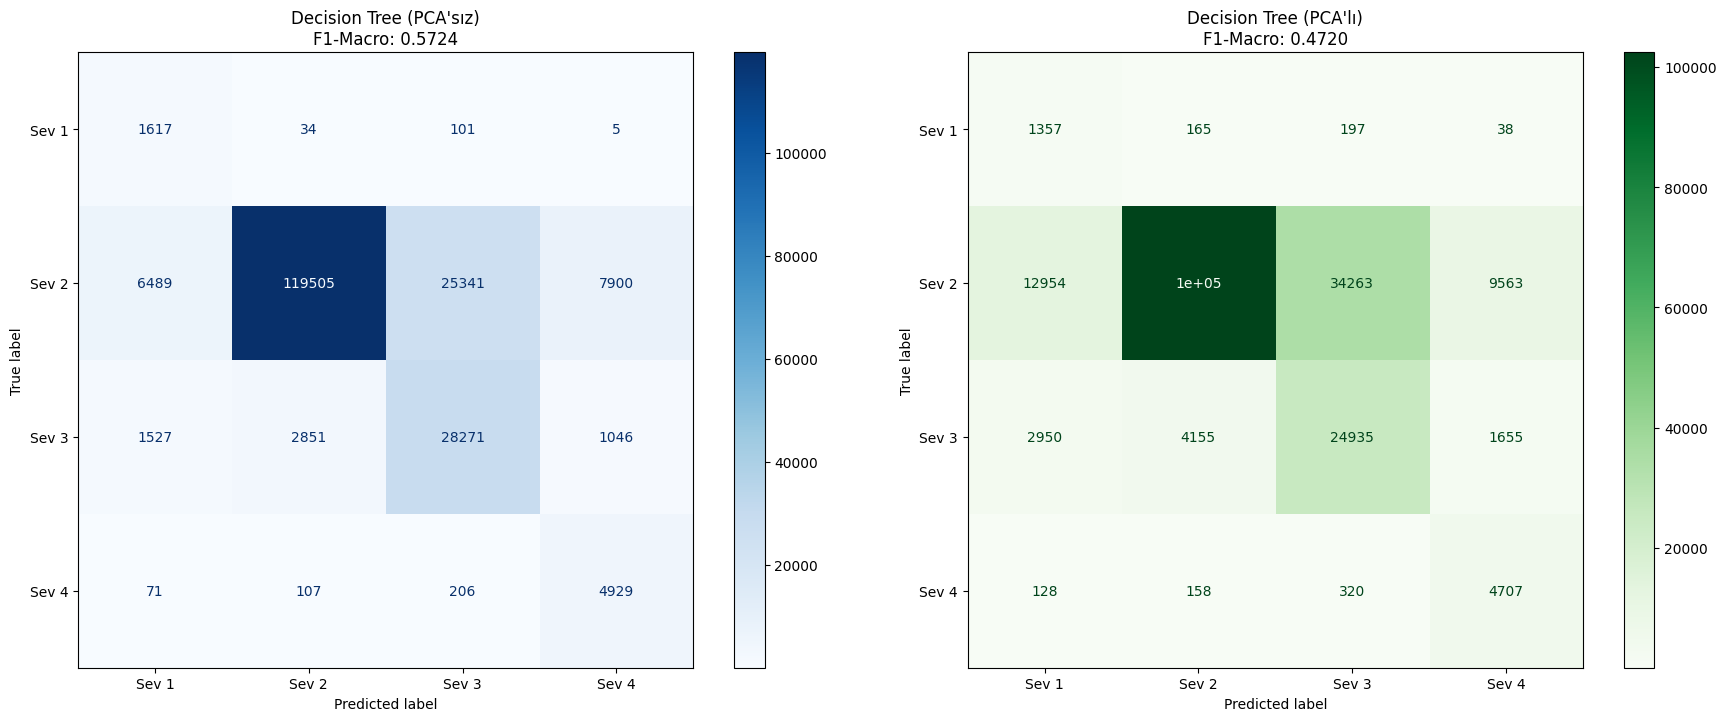




############################################################
### BÖLÜM 8: ÖZELLİK ÖNEMİ ANALİZİ ###
############################################################


--- En Önemli 20 Özellik (PCA'sız Model) ---
                    feature  importance
26      FEAT_Is_Road_Closed    0.317009
29            FEAT_Is_Crash    0.153160
24            Duration(min)    0.144410
27     FEAT_Is_Lane_Blocked    0.107687
28         FEAT_Is_Slowdown    0.057519
2              Distance(mi)    0.054196
19           Traffic_Signal    0.033567
1                 Start_Lng    0.025097
5              Pressure(in)    0.020494
111  Road_Type_Local_Street    0.017854
0                 Start_Lat    0.013879
54                 State_NC    0.007483
47                 State_MD    0.004377
21                     Hour    0.004175
3            Temperature(F)    0.004131
22               Is_Weekend    0.003654
69                 State_TN    0.003637
25        Is_Low_Speed_Zone    0.003551
31                 State_AZ  

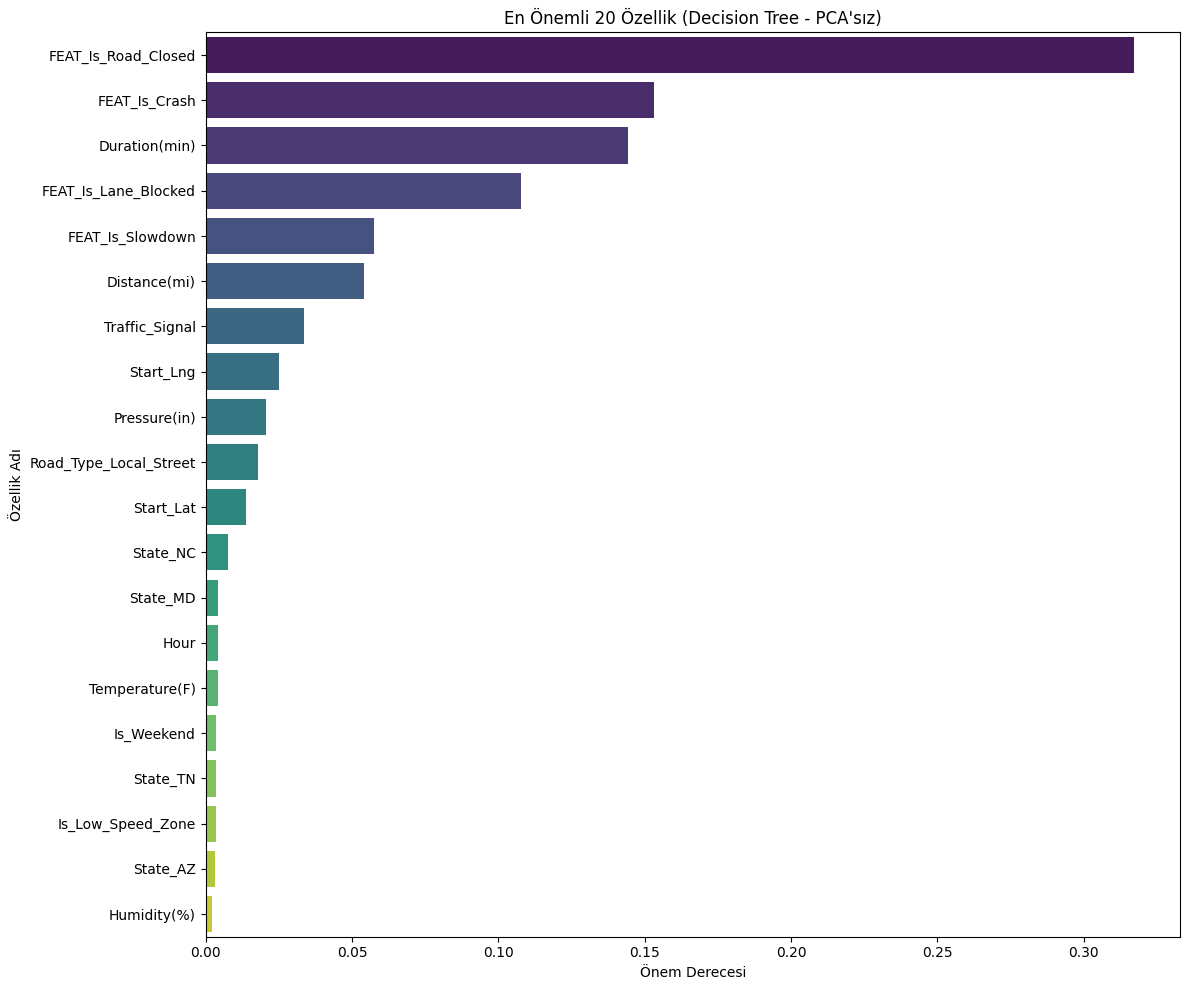


############################################################
### BÖLÜM 9: EN İYİ MODELİN AĞAÇ GÖRSELLEŞTİRMESİ ###
############################################################

... Decision Tree (PCA'sız) karar ağacının ilk 3 seviyesi görselleştiriliyor...


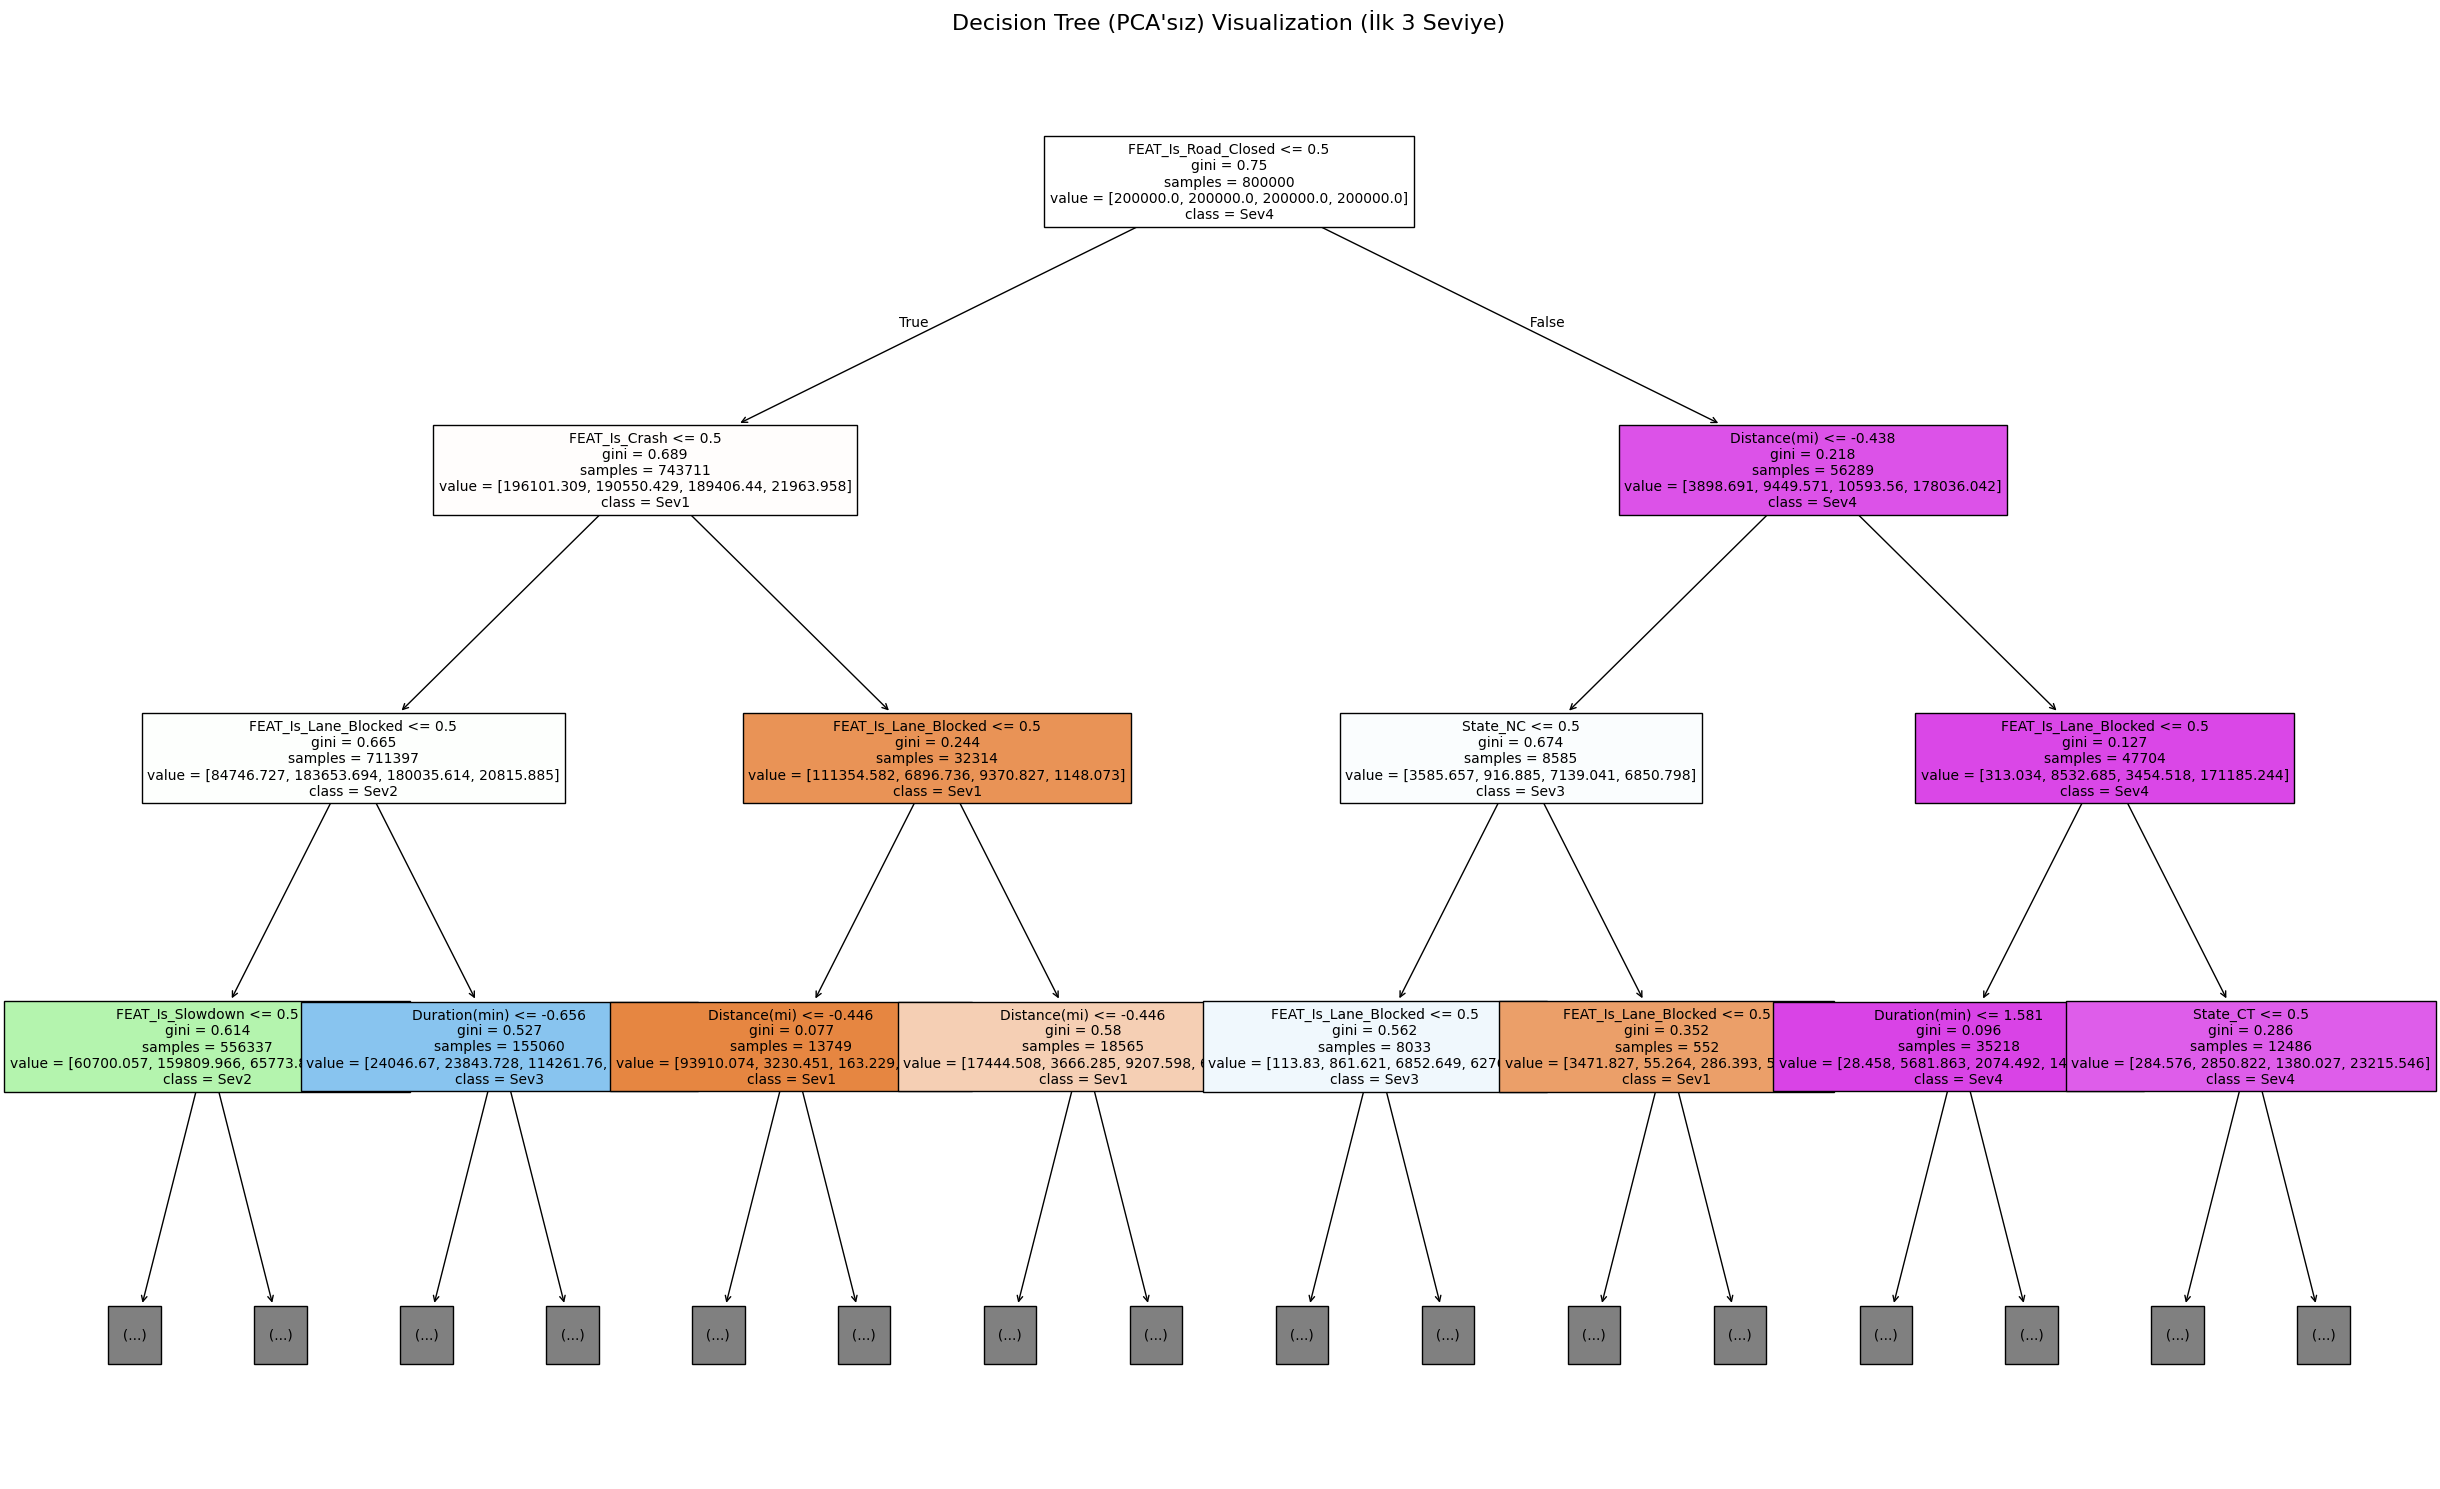



############################################################
### TÜM SÜREÇ TAMAMLANDI! ###
############################################################


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
import warnings
warnings.filterwarnings('ignore')

# Gerekli modelleme ve metrik kütüphaneleri
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.utils.class_weight import compute_class_weight
import time

# ======================================================================================
# --- BÖLÜM 0: KURULUM VE VERİ YÜKLEME ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 0: KURULUM VE VERİ YÜKLEME BAŞLADI ###")
print("############################################################\n")

df = pd.read_csv('usa_acc.csv') 
print("--- Ham veri setinin ilk durumu ---")
print(f"Veri Seti Boyutu: {df.shape}")
print("\n--- Veri Seti Bilgisi (df.info()) ---")
df.info(verbose=False, memory_usage='deep')
print("\n\n")


# ======================================================================================
# --- BÖLÜM 1: ÖRNEKLEME VE VERİ SETLERİNİ AYIRMA ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 1: ÖRNEKLEME VE VERİ SETLERİNİ AYIRMA BAŞLADI ###")
print("############################################################\n")

print("--- 7,000,000 satırlık rastgele bir örneklem alınıyor... ---")
df_sample = df.sample(n=1000000, random_state=42)
del df

print("--- Veri, Eğitim ve Test Setlerine Bölünüyor (Veri Sızıntısını Önlemek İçin EN BAŞTA YAPILIR!) ---")
X = df_sample.drop('Severity', axis=1)
y = df_sample['Severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Eğitim seti boyutu (X_train): {X_train.shape}")
print(f"Test seti boyutu (X_test): {X_test.shape}")
print("\n--- Eğitim Setindeki Sınıf Dağılımı (Dengesizliği Görmek İçin) ---")
print(y_train.value_counts(normalize=True))
print("\n\n")


# ======================================================================================
# --- BÖLÜM 2: ÖZELLİK YARATMA (FEATURE CREATION) ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 2: ÖZELLİK YARATMA BAŞLADI ###")
print("############################################################\n")

def feature_creation_pipeline(df_input):
    df = df_input.copy()
    
    # --- 2A: Zamansal Özellikler ---
    print("... Zamansal özellikler oluşturuluyor...")
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')
    df['Hour'] = df['Start_Time'].dt.hour
    df['DayOfWeek'] = df['Start_Time'].dt.day_name()
    df['Is_Weekend'] = df['DayOfWeek'].isin(['Saturday', 'Sunday'])
    df['Is_Rush_Hour'] = (~df['Is_Weekend']) & (df['Hour'].isin([7, 8, 9, 15, 16, 17, 18]))
    df['Duration(min)'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60
    df.loc[df['Duration(min)'] < 0, 'Duration(min)'] = 0

    # --- 2B: 'Street' Sütunundan Anlam Çıkarma ---
    print("... 'Street' sütunundan Road_Type ve Is_Low_Speed_Zone özellikleri türetiliyor...")
    if 'Street' in df.columns:
        df['Street'].fillna('Unknown', inplace=True)
        highway_keywords = ['Hwy', 'Fwy', 'Pkwy', 'Expy', 'Blvd', 'Highway', 'Freeway', 'I-', 'US-']
        df['Road_Type'] = df['Street'].apply(lambda x: 'Highway/Main_Road' if any(kw in str(x) for kw in highway_keywords) else 'Local_Street')
        low_speed_keywords = ['St', 'Dr', 'Ave', 'Rd', 'Ln', 'Ct', 'Pl']
        pattern = r'\b(' + '|'.join(low_speed_keywords) + r')\b'
        df['Is_Low_Speed_Zone'] = df['Street'].str.contains(pattern, case=False, na=False)

    # --- 2C: 'Description' Sütunundan Metin Madenciliği ---
    print("... 'Description' sütunundan metin bazlı özellikler kazınıyor...")
    if 'Description' in df.columns:
        desc_lower = df['Description'].str.lower().fillna('')
        df['FEAT_Is_Road_Closed'] = desc_lower.str.contains('closed|closure', na=False)
        df['FEAT_Is_Lane_Blocked'] = desc_lower.str.contains('blocked|lane', na=False)
        df['FEAT_Is_Slowdown'] = desc_lower.str.contains('traffic|slow|caution', na=False)
        df['FEAT_Is_Crash'] = desc_lower.str.contains('crash', na=False)
        
    return df

X_train_created = feature_creation_pipeline(X_train)
X_test_created = feature_creation_pipeline(X_test)

print("\n--- Eğitim Seti (X_train_created) Özellik Yaratma Sonrası Durum ---")
print(f"Boyut: {X_train_created.shape}")
print(f"Toplam Eksik Veri: {X_train_created.isnull().sum().sum()}")
print("\n\n")


# ======================================================================================
# --- BÖLÜM 3: ÖZELLİK SEÇİMİ (FEATURE SELECTION) ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 3: ÖZELLİK SEÇİMİ VE TEMİZLEME BAŞLADI ###")
print("############################################################\n")

cols_to_drop = [
    'ID', 'Source', 'End_Lat', 'End_Lng', 'County', 'Zipcode', 'Country', 
    'Start_Time', 'End_Time', 'Timezone', 'Airport_Code', 
    'Street', 'Description', 
    'Weather_Timestamp', 'Wind_Chill(F)', 'Precipitation(in)', 'Weather_Condition'
]
print(f"--- Silinecek {len(cols_to_drop)} sütun var. ---")
X_train_selected = X_train_created.drop(columns=cols_to_drop, errors='ignore')
X_test_selected = X_test_created.drop(columns=cols_to_drop, errors='ignore')

print("\n--- Eğitim Seti (X_train_selected) Özellik Seçimi Sonrası Durum ---")
print(f"Boyut: {X_train_selected.shape}")
print(f"Toplam Eksik Veri: {X_train_selected.isnull().sum().sum()}")
print("\n\n")


# ======================================================================================
# --- BÖLÜM 4: VERİ TEMİZLEME (IMPUTATION VE OUTLIER) ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 4: VERİ TEMİZLEME BAŞLADI ###")
print("############################################################\n")

# --- 4A: Akıllı Doldurma ve 'City' Sütununu Silme ---
print("... Şehir bazlı medyan ile sıcaklık dolduruluyor...")
city_median_temps_map = X_train_selected.groupby('City')['Temperature(F)'].median()
X_train_imputed = X_train_selected.copy()
X_test_imputed = X_test_selected.copy()
X_train_imputed['Temperature(F)'].fillna(X_train_imputed['City'].map(city_median_temps_map), inplace=True)
X_test_imputed['Temperature(F)'].fillna(X_test_imputed['City'].map(city_median_temps_map), inplace=True)
X_train_imputed.drop(columns=['City'], inplace=True)
X_test_imputed.drop(columns=['City'], inplace=True)

# --- 4B: Aykırı Değer Yönetimi (Clipping) ---
print("... Aykırı değerler temizleniyor (Clipping)...")
cols_to_clip = [col for col in ['Temperature(F)', 'Wind_Speed(mph)', 'Distance(mi)', 'Duration(min)', 'Pressure(in)', 'Humidity(%)', 'Visibility(mi)'] if col in X_train_imputed.columns]
for col in cols_to_clip:
    lower, upper = X_train_imputed[col].quantile(0.01), X_train_imputed[col].quantile(0.99)
    X_train_imputed[col] = X_train_imputed[col].clip(lower=lower, upper=upper)
    X_test_imputed[col] = X_test_imputed[col].clip(lower=lower, upper=upper)

# --- 4C: Kalan Eksik Verileri Doldurma ---
print("... Kalan tüm eksik veriler dolduruluyor...")
fill_values = {col: (X_train_imputed[col].median() if pd.api.types.is_numeric_dtype(X_train_imputed[col]) else X_train_imputed[col].mode()[0]) for col in X_train_imputed.columns if X_train_imputed[col].isnull().sum() > 0}
X_train_imputed.fillna(value=fill_values, inplace=True)
X_test_imputed.fillna(value=fill_values, inplace=True)

print("\n--- Eğitim Seti (X_train_imputed) Veri Temizleme Sonrası Durum ---")
print(f"Boyut: {X_train_imputed.shape}")
print(f"Toplam Eksik Veri: {X_train_imputed.isnull().sum().sum()}")
print("\n\n")


# ======================================================================================
# --- BÖLÜM 5: MODELLEME İÇİN SON HAZIRLIK (ENCODING VE SCALING) ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 5: MODELLEME İÇİN SON HAZIRLIK BAŞLADI ###")
print("############################################################\n")

# --- 5A: Kategorik Değişkenlerin Kodlanması (One-Hot Encoding) ---
print("... Kategorik değişkenler sayısala çevriliyor (One-Hot Encoding)...")
categorical_cols = X_train_imputed.select_dtypes(include='object').columns.tolist()
print(f"One-Hot Encoding uygulanacak sütunlar: {categorical_cols}")
X_train_encoded = pd.get_dummies(X_train_imputed, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_imputed, columns=categorical_cols, drop_first=True)
train_cols, test_cols = X_train_encoded.columns, X_test_encoded.columns
missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test: X_test_encoded[c] = False
X_test_encoded = X_test_encoded[train_cols]

# --- 5B: Sayısal Değişkenlerin Ölçeklendirilmesi (Scaling) ---
print("... Sayısal değişkenler ölçeklendiriliyor (StandardScaler)...")
cols_to_scale = [col for col in X_train_imputed.select_dtypes(include=np.number).columns if col in X_train_encoded.columns]
scaler = StandardScaler()
X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train_encoded[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test_encoded[cols_to_scale])

print(f"\n--- Ölçeklendirme Sonrası Boyut: {X_train_scaled.shape}")
print(f"Toplam özellik sayısı: {X_train_scaled.shape[1]}")
print("\n\n")


# ======================================================================================
# --- BÖLÜM 5.5: PCA (PRINCIPAL COMPONENT ANALYSIS) UYGULAMASI ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 5.5: PCA BOYUT İNDİRGEME BAŞLADI ###")
print("############################################################\n")

# Varyansın %95'ini koruyacak şekilde PCA uygula
print("... PCA uygulanıyor (Varyansın %95'i korunuyor)...")
pca = PCA(n_components=0.95, random_state=42)

start_pca = time.time()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
end_pca = time.time()

print(f"✅ PCA tamamlandı! Süre: {end_pca - start_pca:.2f} saniye")
print(f"\n--- PCA Sonuçları ---")
print(f"Orijinal özellik sayısı: {X_train_scaled.shape[1]}")
print(f"PCA sonrası özellik sayısı: {X_train_pca.shape[1]}")
print(f"Boyut indirgeme oranı: %{(1 - X_train_pca.shape[1]/X_train_scaled.shape[1])*100:.2f}")
print(f"Açıklanan toplam varyans: %{pca.explained_variance_ratio_.sum()*100:.2f}")

# İlk 10 bileşenin açıklama gücü
print(f"\nİlk 10 bileşenin açıkladığı varyans:")
for i, var in enumerate(pca.explained_variance_ratio_[:10], 1):
    print(f"  PC{i}: %{var*100:.2f}")

# PCA varyans grafiği
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Bileşen Sayısı')
plt.ylabel('Kümülatif Açıklanan Varyans')
plt.title('PCA: Kümülatif Varyans Açıklama Grafiği')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='%95 Varyans')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(range(1, min(21, len(pca.explained_variance_ratio_)+1)), pca.explained_variance_ratio_[:20])
plt.xlabel('Bileşen')
plt.ylabel('Açıklanan Varyans Oranı')
plt.title('İlk 20 PCA Bileşeninin Varyans Katkısı')
plt.xticks(range(1, min(21, len(pca.explained_variance_ratio_)+1)))
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

print("\n\n")


# ======================================================================================
# --- BÖLÜM 6: DECISION TREE İLE MODEL EĞİTİMİ (PCA'Lİ VE PCA'SIZ KARŞILAŞTIRMA) ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 6: DECISION TREE MODEL EĞİTİMİ VE OPTİMİZASYON ###")
print("############################################################\n")

# --- 6A: Hedef Değişkeni Ayarlama ---
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1
print(f"Ayarlanmış y_train değerleri: {np.sort(y_train_adjusted.unique())}")

# --- 6B: Sınıf Dengesizliği için Ağırlık Hesaplama ---
print("... Sınıf dengesizliği için sınıf ağırlıkları hesaplanıyor...")
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_adjusted), y=y_train_adjusted)
class_weight_dict = dict(enumerate(class_weights))
print(f"Sınıf ağırlıkları: {class_weight_dict}")

# --- 6C: GridSearchCV ile Hiperparametre Optimizasyonu (PCA'SIZ) ---
print("\n" + "="*60)
print("DENEY 1: PCA OLMADAN DECISION TREE")
print("="*60)
print("\n... GridSearchCV ile en iyi hiperparametreler aranıyor...")

param_grid = {
    'max_depth': [15, 20, 25],
    'min_samples_split': [500, 1000],
    'min_samples_leaf': [100, 200],
    'criterion': ['gini', 'entropy']
}

dt_base = DecisionTreeClassifier(
    random_state=42,
    class_weight=class_weight_dict
)

grid_search_no_pca = GridSearchCV(
    dt_base,
    param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
grid_search_no_pca.fit(X_train_scaled, y_train_adjusted)
end_time = time.time()

print(f"\n✅ GridSearch (PCA'sız) tamamlandı! Süre: {end_time - start_time:.2f} saniye")
print(f"En İyi Hiperparametreler: {grid_search_no_pca.best_params_}")
print(f"En İyi CV F1-Macro Skoru: {grid_search_no_pca.best_score_:.4f}")

best_model_no_pca = grid_search_no_pca.best_estimator_

# Test seti değerlendirmesi
y_pred_no_pca = best_model_no_pca.predict(X_test_scaled)
macro_f1_no_pca = f1_score(y_test_adjusted, y_pred_no_pca, average='macro')
print(f"🎯 Test Seti Macro F1-Score (PCA'sız): {macro_f1_no_pca:.4f}")


# --- 6D: GridSearchCV ile Hiperparametre Optimizasyonu (PCA'LI) ---
print("\n" + "="*60)
print("DENEY 2: PCA İLE DECISION TREE")
print("="*60)
print("\n... GridSearchCV ile en iyi hiperparametreler aranıyor (PCA'lı veri)...")

grid_search_pca = GridSearchCV(
    dt_base,
    param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
grid_search_pca.fit(X_train_pca, y_train_adjusted)
end_time = time.time()

print(f"\n✅ GridSearch (PCA'lı) tamamlandı! Süre: {end_time - start_time:.2f} saniye")
print(f"En İyi Hiperparametreler: {grid_search_pca.best_params_}")
print(f"En İyi CV F1-Macro Skoru: {grid_search_pca.best_score_:.4f}")

best_model_pca = grid_search_pca.best_estimator_

# Test seti değerlendirmesi
y_pred_pca = best_model_pca.predict(X_test_pca)
macro_f1_pca = f1_score(y_test_adjusted, y_pred_pca, average='macro')
print(f"🎯 Test Seti Macro F1-Score (PCA'lı): {macro_f1_pca:.4f}")

print("\n\n")


# ======================================================================================
# --- BÖLÜM 7: MODEL KARŞILAŞTIRMASI VE DEĞERLENDİRME ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 7: MODEL KARŞILAŞTIRMASI VE DEĞERLENDİRME ###")
print("############################################################\n")

# Karşılaştırma tablosu
comparison_df = pd.DataFrame({
    'Model': ['Decision Tree (PCA\'sız)', 'Decision Tree (PCA\'lı)'],
    'Özellik Sayısı': [X_train_scaled.shape[1], X_train_pca.shape[1]],
    'CV F1-Macro': [grid_search_no_pca.best_score_, grid_search_pca.best_score_],
    'Test F1-Macro': [macro_f1_no_pca, macro_f1_pca]
})

print("\n--- PCA'LI VE PCA'SIZ MODEL KARŞILAŞTIRMASI ---")
print(comparison_df.to_string(index=False))

# En iyi modeli seç
if macro_f1_pca > macro_f1_no_pca:
    print(f"\n✅ KAZANAN: PCA'lı Model ({macro_f1_pca:.4f} F1-Score)")
    best_model = best_model_pca
    X_test_final = X_test_pca
    y_pred_final = y_pred_pca
    model_name = "Decision Tree (PCA'lı)"
else:
    print(f"\n✅ KAZANAN: PCA'sız Model ({macro_f1_no_pca:.4f} F1-Score)")
    best_model = best_model_no_pca
    X_test_final = X_test_scaled
    y_pred_final = y_pred_no_pca
    model_name = "Decision Tree (PCA'sız)"

print("\n--- EN İYİ MODELİN DETAYLI RAPORU ---")
print(classification_report(y_test_adjusted, y_pred_final, 
                          target_names=['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']))

# Confusion Matrix
print("\n--- Karmaşıklık Matrisi Görselleştiriliyor... ---")
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# PCA'sız model
cm_no_pca = confusion_matrix(y_test_adjusted, y_pred_no_pca)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_no_pca, 
                                display_labels=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4'])
disp1.plot(cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title(f"Decision Tree (PCA'sız)\nF1-Macro: {macro_f1_no_pca:.4f}")

# PCA'lı model
cm_pca = confusion_matrix(y_test_adjusted, y_pred_pca)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_pca, 
                               display_labels=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4'])
disp2.plot(cmap=plt.cm.Greens, ax=axes[1])
axes[1].set_title(f"Decision Tree (PCA'lı)\nF1-Macro: {macro_f1_pca:.4f}")

plt.tight_layout()
plt.show()

print("\n\n")


# ======================================================================================
# --- BÖLÜM 8: ÖZELLİK ÖNEMİ ANALİZİ (PCA'SIZ MODEL İÇİN) ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 8: ÖZELLİK ÖNEMİ ANALİZİ ###")
print("############################################################\n")

# PCA'sız modelin özellik önemleri (PCA'lı modelde bu anlamsız olur)
feature_importances = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': best_model_no_pca.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- En Önemli 20 Özellik (PCA'sız Model) ---")
print(feature_importances.head(20))

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')
plt.title('En Önemli 20 Özellik (Decision Tree - PCA\'sız)')
plt.xlabel('Önem Derecesi')
plt.ylabel('Özellik Adı')
plt.tight_layout()
plt.show()


# ======================================================================================
# --- BÖLÜM 9: AĞAÇ GÖRSELLEŞTİRME ---
# ======================================================================================
print("\n############################################################")
print("### BÖLÜM 9: EN İYİ MODELİN AĞAÇ GÖRSELLEŞTİRMESİ ###")
print("############################################################\n")

print(f"... {model_name} karar ağacının ilk 3 seviyesi görselleştiriliyor...")
plt.figure(figsize=(25, 15))

if model_name == "Decision Tree (PCA'sız)":
    plot_tree(
        best_model,
        max_depth=3,
        feature_names=X_train_scaled.columns,
        class_names=['Sev1', 'Sev2', 'Sev3', 'Sev4'],
        filled=True,
        fontsize=10
    )
else:
    # PCA'lı model için PC1, PC2, ... şeklinde isimlendir
    pca_feature_names = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
    plot_tree(
        best_model,
        max_depth=3,
        feature_names=pca_feature_names,
        class_names=['Sev1', 'Sev2', 'Sev3', 'Sev4'],
        filled=True,
        fontsize=10
    )

plt.title(f'{model_name} Visualization (İlk 3 Seviye)', fontsize=16)
plt.tight_layout()
plt.show()

print("\n\n############################################################")
print("### TÜM SÜREÇ TAMAMLANDI! ###")
print("############################################################")

############################################################
### BÖLÜM 0: KURULUM VE VERİ YÜKLEME BAŞLADI ###
############################################################

--- Ham veri setinin ilk durumu ---
Veri Seti Boyutu: (7728394, 46)



############################################################
### BÖLÜM 1: ÖRNEKLEME VE VERİ SETLERİNİ AYIRMA BAŞLADI ###
############################################################

--- 2,000,000 satırlık rastgele bir örneklem alınıyor... ---
--- Veri, Eğitim ve Test Setlerine Bölünüyor ---
Eğitim seti boyutu (X_train): (400000, 45)
Test seti boyutu (X_test): (100000, 45)

--- Eğitim Setindeki Sınıf Dağılımı ---
Severity
2    0.795530
3    0.169085
4    0.026617
1    0.008767
Name: proportion, dtype: float64



############################################################
### BÖLÜM 2: ÖZELLİK YARATMA BAŞLADI ###
############################################################

... Zamansal özellikler oluşturuluyor...
... 'Street' sütunundan özellikler

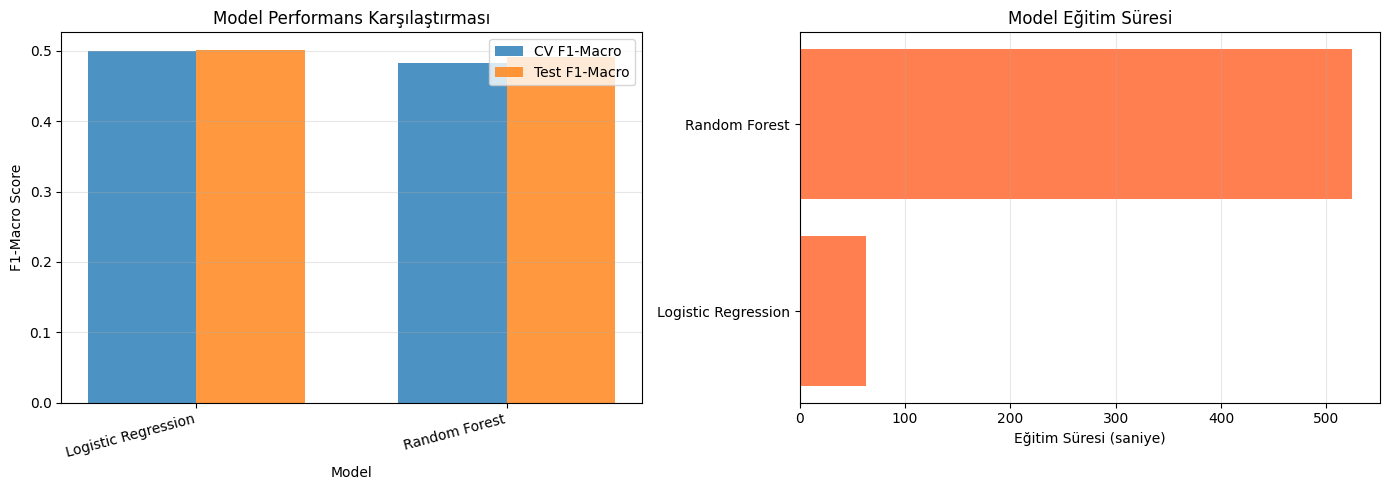




############################################################
### BÖLÜM 10: EN İYİ MODELİN DETAYLI DEĞERLENDİRMESİ ###
############################################################


--- Logistic Regression Classification Report ---
              precision    recall  f1-score   support

  Severity 1       0.09      0.85      0.16       876
  Severity 2       0.95      0.69      0.80     79553
  Severity 3       0.46      0.71      0.56     16909
  Severity 4       0.33      0.90      0.49      2662

    accuracy                           0.70    100000
   macro avg       0.46      0.79      0.50    100000
weighted avg       0.84      0.70      0.75    100000



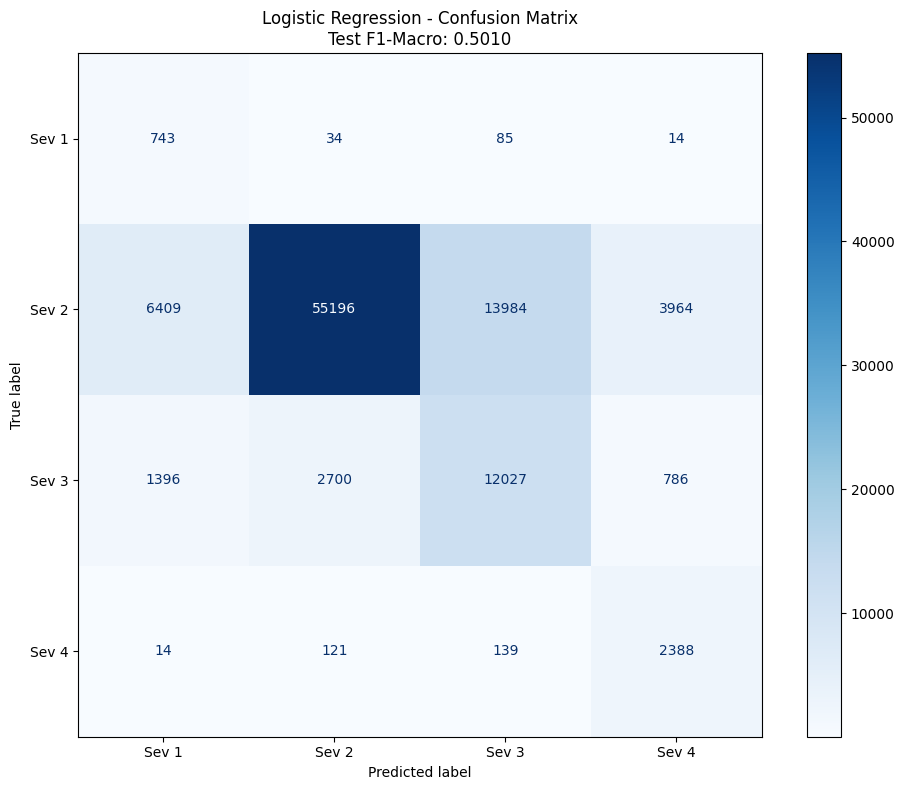

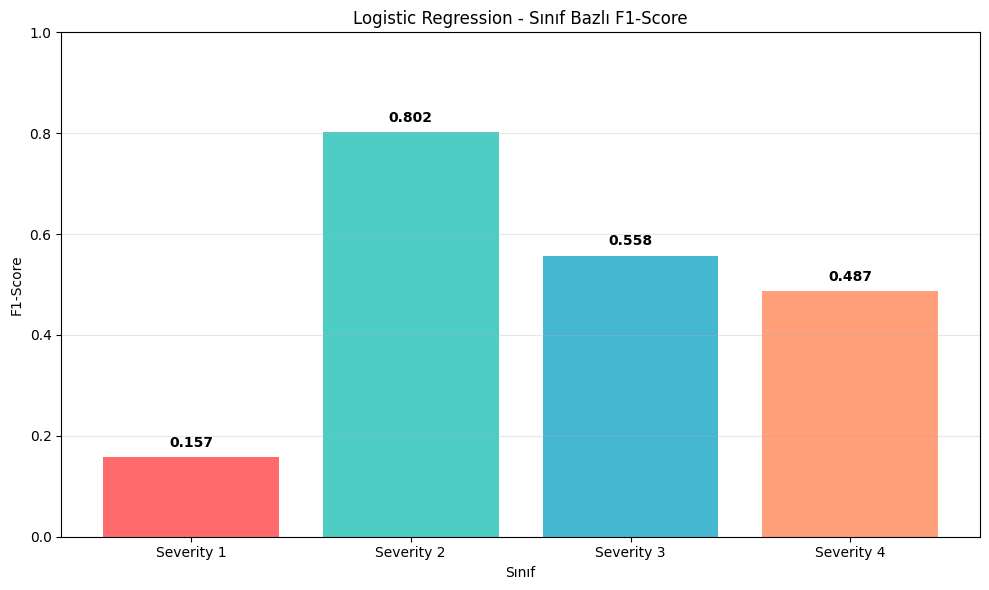




############################################################
### BÖLÜM 11: PCA ANALİZİ ###
############################################################

PCA İstatistikleri:
  - Orijinal özellik sayısı: 108
  - PCA sonrası bileşen sayısı: 90
  - Açıklanan toplam varyans: %95.39


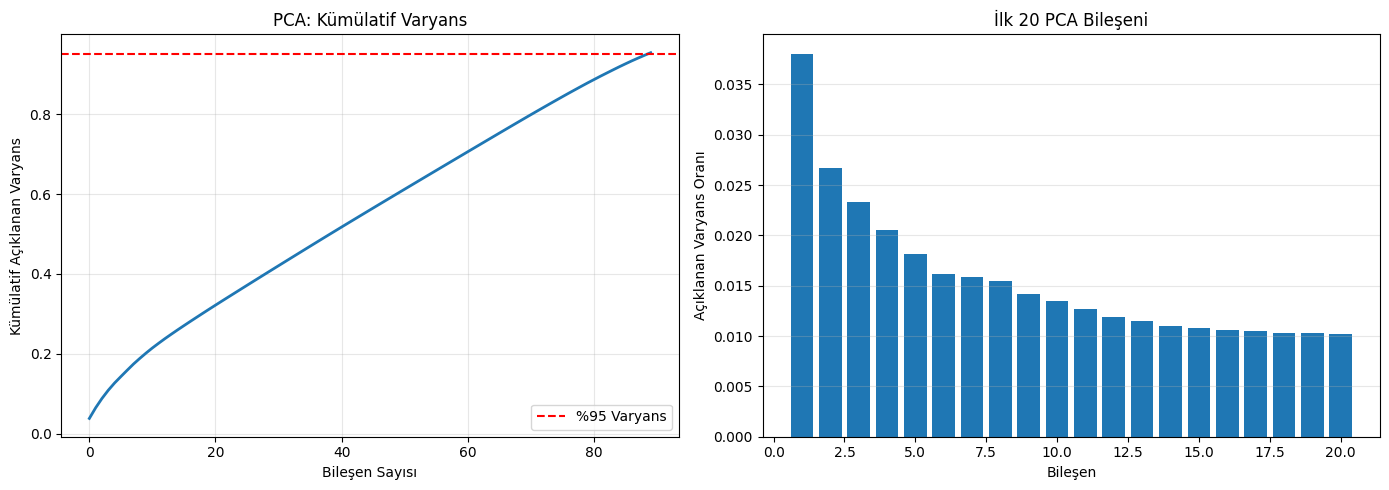



############################################################
### 🎉 TÜM SÜREÇ TAMAMLANDI! 🎉 ###
############################################################

🏆 En İyi Model: Logistic Regression
🎯 Test F1-Macro: 0.5010
⏱️  Toplam Süre: 587.64 saniye


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight
import time

# ======================================================================================
# --- BÖLÜM 0: KURULUM VE VERİ YÜKLEME ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 0: KURULUM VE VERİ YÜKLEME BAŞLADI ###")
print("############################################################\n")

df = pd.read_csv('usa_acc.csv') 
print("--- Ham veri setinin ilk durumu ---")
print(f"Veri Seti Boyutu: {df.shape}")
print("\n\n")


# ======================================================================================
# --- BÖLÜM 1: ÖRNEKLEME VE VERİ SETLERİNİ AYIRMA ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 1: ÖRNEKLEME VE VERİ SETLERİNİ AYIRMA BAŞLADI ###")
print("############################################################\n")

# 🔥 VERİYİ KÜÇÜLT: 2M yeterli ve 3-4 kat daha hızlı!
print("--- 2,000,000 satırlık rastgele bir örneklem alınıyor... ---")
df_sample = df.sample(n=500000, random_state=42)
del df

print("--- Veri, Eğitim ve Test Setlerine Bölünüyor ---")
X = df_sample.drop('Severity', axis=1)
y = df_sample['Severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Eğitim seti boyutu (X_train): {X_train.shape}")
print(f"Test seti boyutu (X_test): {X_test.shape}")
print("\n--- Eğitim Setindeki Sınıf Dağılımı ---")
print(y_train.value_counts(normalize=True))
print("\n\n")


# ======================================================================================
# --- BÖLÜM 2: ÖZELLİK YARATMA (FEATURE CREATION) ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 2: ÖZELLİK YARATMA BAŞLADI ###")
print("############################################################\n")

def feature_creation_pipeline(df_input):
    df = df_input.copy()
    
    print("... Zamansal özellikler oluşturuluyor...")
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')
    df['Hour'] = df['Start_Time'].dt.hour
    df['Month'] = df['Start_Time'].dt.month
    df['DayOfWeek'] = df['Start_Time'].dt.dayofweek
    df['Is_Weekend'] = (df['DayOfWeek'] >= 5).astype(int)
    df['Is_Rush_Hour'] = ((df['Is_Weekend'] == 0) & (df['Hour'].isin([7, 8, 9, 15, 16, 17, 18]))).astype(int)
    df['Duration(min)'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60
    df.loc[df['Duration(min)'] < 0, 'Duration(min)'] = 0

    print("... 'Street' sütunundan özellikler türetiliyor...")
    if 'Street' in df.columns:
        df['Street'].fillna('Unknown', inplace=True)
        highway_keywords = ['Hwy', 'Fwy', 'Pkwy', 'Expy', 'Blvd', 'Highway', 'Freeway', 'I-', 'US-']
        df['Is_Highway'] = df['Street'].apply(lambda x: 1 if any(kw in str(x) for kw in highway_keywords) else 0)
        low_speed_keywords = ['St', 'Dr', 'Ave', 'Rd', 'Ln', 'Ct', 'Pl']
        pattern = r'\b(' + '|'.join(low_speed_keywords) + r')\b'
        df['Is_Low_Speed_Zone'] = df['Street'].str.contains(pattern, case=False, na=False).astype(int)

    print("... 'Description' sütunundan metin bazlı özellikler kazınıyor...")
    if 'Description' in df.columns:
        desc_lower = df['Description'].str.lower().fillna('')
        df['FEAT_Is_Road_Closed'] = desc_lower.str.contains('closed|closure', na=False).astype(int)
        df['FEAT_Is_Lane_Blocked'] = desc_lower.str.contains('blocked|lane', na=False).astype(int)
        df['FEAT_Is_Slowdown'] = desc_lower.str.contains('traffic|slow|caution', na=False).astype(int)
        df['FEAT_Is_Crash'] = desc_lower.str.contains('crash', na=False).astype(int)
        
    return df

X_train_created = feature_creation_pipeline(X_train)
X_test_created = feature_creation_pipeline(X_test)

print(f"\n--- Boyut: {X_train_created.shape}")
print("\n\n")


# ======================================================================================
# --- BÖLÜM 3: ÖZELLİK SEÇİMİ ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 3: ÖZELLİK SEÇİMİ VE TEMİZLEME BAŞLADI ###")
print("############################################################\n")

cols_to_drop = [
    'ID', 'Source', 'End_Lat', 'End_Lng', 'County', 'Zipcode', 'Country', 
    'Start_Time', 'End_Time', 'Timezone', 'Airport_Code', 
    'Street', 'Description',
    'Weather_Timestamp', 'Wind_Chill(F)', 'Precipitation(in)', 'Weather_Condition'
]
X_train_selected = X_train_created.drop(columns=cols_to_drop, errors='ignore')
X_test_selected = X_test_created.drop(columns=cols_to_drop, errors='ignore')

print(f"Boyut: {X_train_selected.shape}\n\n")


# ======================================================================================
# --- BÖLÜM 4: VERİ TEMİZLEME ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 4: VERİ TEMİZLEME BAŞLADI ###")
print("############################################################\n")

print("... Şehir bazlı medyan ile sıcaklık dolduruluyor...")
city_median_temps_map = X_train_selected.groupby('City')['Temperature(F)'].median()
X_train_imputed = X_train_selected.copy()
X_test_imputed = X_test_selected.copy()
X_train_imputed['Temperature(F)'].fillna(X_train_imputed['City'].map(city_median_temps_map), inplace=True)
X_test_imputed['Temperature(F)'].fillna(X_test_imputed['City'].map(city_median_temps_map), inplace=True)
X_train_imputed.drop(columns=['City'], inplace=True)
X_test_imputed.drop(columns=['City'], inplace=True)

print("... Aykırı değerler temizleniyor...")
cols_to_clip = [col for col in ['Temperature(F)', 'Wind_Speed(mph)', 'Distance(mi)', 'Duration(min)', 'Pressure(in)', 'Humidity(%)', 'Visibility(mi)'] if col in X_train_imputed.columns]
for col in cols_to_clip:
    lower, upper = X_train_imputed[col].quantile(0.01), X_train_imputed[col].quantile(0.99)
    X_train_imputed[col] = X_train_imputed[col].clip(lower=lower, upper=upper)
    X_test_imputed[col] = X_test_imputed[col].clip(lower=lower, upper=upper)

print("... Kalan eksik veriler dolduruluyor...")
fill_values = {col: (X_train_imputed[col].median() if pd.api.types.is_numeric_dtype(X_train_imputed[col]) else X_train_imputed[col].mode()[0]) for col in X_train_imputed.columns if X_train_imputed[col].isnull().sum() > 0}
X_train_imputed.fillna(value=fill_values, inplace=True)
X_test_imputed.fillna(value=fill_values, inplace=True)

print(f"Boyut: {X_train_imputed.shape}\n\n")


# ======================================================================================
# --- BÖLÜM 5: SAYISALLAŞTIRMA ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 5: TÜM VERİYİ SAYISALLAŞTIRMA ###")
print("############################################################\n")

bool_cols = X_train_imputed.select_dtypes(include='bool').columns
X_train_imputed[bool_cols] = X_train_imputed[bool_cols].astype(int)
X_test_imputed[bool_cols] = X_test_imputed[bool_cols].astype(int)

categorical_cols = X_train_imputed.select_dtypes(include='object').columns.tolist()
if len(categorical_cols) > 0:
    print(f"Kategorik sütunlar: {categorical_cols}")
    X_train_final = pd.get_dummies(X_train_imputed, columns=categorical_cols, drop_first=True)
    X_test_final = pd.get_dummies(X_test_imputed, columns=categorical_cols, drop_first=True)
    
    missing_in_test = set(X_train_final.columns) - set(X_test_final.columns)
    for c in missing_in_test: 
        X_test_final[c] = 0
    X_test_final = X_test_final[X_train_final.columns]
else:
    X_train_final = X_train_imputed.copy()
    X_test_final = X_test_imputed.copy()

print(f"Final boyut: {X_train_final.shape}\n\n")


# ======================================================================================
# --- BÖLÜM 6: HEDEF DEĞİŞKEN ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 6: HEDEF DEĞİŞKENİ AYARLAMA ###")
print("############################################################\n")

y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1
print(f"Sınıflar: {np.sort(y_train_adjusted.unique())}\n\n")


# ======================================================================================
# --- BÖLÜM 7: HIZLI PİPELINE MİMARİSİ (2 MODEL) ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 7: HIZLI PIPELİNE MİMARİSİ (2 MODEL) ###")
print("############################################################\n")

f1_scorer = make_scorer(f1_score, average='macro')

# 🔥 SADECE 2 MODEL - HIZLI VE ETKİLİ
models_and_params = {
    'Logistic Regression': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(random_state=42)),
            ('clf', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced', n_jobs=-1))
        ]),
        'params': {
            'pca__n_components': [0.95],  # Sadece 1 değer
            'clf__C': [1, 10],  # 2 değer
            'clf__solver': ['lbfgs']  # 1 değer
        }
    },
    
    'Random Forest': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.95, random_state=42)),  # PCA sabit
            ('clf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
        ]),
        'params': {
            'clf__n_estimators': [100, 200],  # 2 değer
            'clf__max_depth': [20],  # 1 değer
            'clf__min_samples_split': [1000],  # 1 değer
            'clf__min_samples_leaf': [200]  # 1 değer
        }
    }
}

print("📋 Tanımlanan modeller: Logistic Regression, Random Forest")
print("⚡ Toplam kombinasyon: ~6-8 (Çok hızlı!)\n\n")


# ======================================================================================
# --- BÖLÜM 8: HIZLI MODEL EĞİTİMİ ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 8: MODEL EĞİTİMİ (HIZLI VERSIYON) ###")
print("############################################################\n")

results = {}

for model_name, config in models_and_params.items():
    print("\n" + "="*70)
    print(f"🚀 {model_name.upper()} EĞİTİMİ BAŞLIYOR")
    print("="*70)
    
    pipeline = config['pipeline']
    param_grid = config['params']
    
    kombinasyon_sayisi = np.prod([len(v) for v in param_grid.values()])
    print(f"Test edilecek kombinasyon: {kombinasyon_sayisi}")
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=3,
        scoring=f1_scorer,
        n_jobs=-1,
        verbose=2  # İlerlemeyi göster
    )
    
    start_time = time.time()
    grid_search.fit(X_train_final, y_train_adjusted)
    end_time = time.time()
    
    y_pred = grid_search.best_estimator_.predict(X_test_final)
    test_f1 = f1_score(y_test_adjusted, y_pred, average='macro')
    
    results[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'cv_f1_score': grid_search.best_score_,
        'test_f1_score': test_f1,
        'training_time': end_time - start_time,
        'y_pred': y_pred
    }
    
    print(f"\n✅ {model_name} Tamamlandı!")
    print(f"   ⏱️  Eğitim Süresi: {end_time - start_time:.2f} saniye")
    print(f"   🎯 CV F1-Macro: {grid_search.best_score_:.4f}")
    print(f"   🎯 Test F1-Macro: {test_f1:.4f}")
    print(f"   ⚙️  En İyi Parametreler: {grid_search.best_params_}")

print("\n\n")


# ======================================================================================
# --- BÖLÜM 9: MODEL KARŞILAŞTIRMASI ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 9: MODEL KARŞILAŞTIRMASI ###")
print("############################################################\n")

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV F1-Macro': [r['cv_f1_score'] for r in results.values()],
    'Test F1-Macro': [r['test_f1_score'] for r in results.values()],
    'Eğitim Süresi (sn)': [r['training_time'] for r in results.values()]
}).sort_values('Test F1-Macro', ascending=False)

print("\n📊 MODEL PERFORMANS TABLOSU")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

best_model_name = comparison_df.iloc[0]['Model']
best_model_info = results[best_model_name]

print(f"\n🏆 EN İYİ MODEL: {best_model_name}")
print(f"   Test F1-Macro: {best_model_info['test_f1_score']:.4f}")

# Karşılaştırma grafiği
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(comparison_df))
width = 0.35
axes[0].bar(x - width/2, comparison_df['CV F1-Macro'], width, label='CV F1-Macro', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['Test F1-Macro'], width, label='Test F1-Macro', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('F1-Macro Score')
axes[0].set_title('Model Performans Karşılaştırması')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].barh(comparison_df['Model'], comparison_df['Eğitim Süresi (sn)'], color='coral')
axes[1].set_xlabel('Eğitim Süresi (saniye)')
axes[1].set_title('Model Eğitim Süresi')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n\n")


# ======================================================================================
# --- BÖLÜM 10: DETAYLI DEĞERLENDİRME ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 10: EN İYİ MODELİN DETAYLI DEĞERLENDİRMESİ ###")
print("############################################################\n")

best_y_pred = best_model_info['y_pred']

print(f"\n--- {best_model_name} Classification Report ---")
print(classification_report(y_test_adjusted, best_y_pred, 
                          target_names=['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']))

# Confusion Matrix
cm = confusion_matrix(y_test_adjusted, best_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4'])
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title(f'{best_model_name} - Confusion Matrix\nTest F1-Macro: {best_model_info["test_f1_score"]:.4f}')
plt.tight_layout()
plt.show()

# Sınıf bazlı F1-Score
class_f1_scores = f1_score(y_test_adjusted, best_y_pred, average=None)
plt.figure(figsize=(10, 6))
plt.bar(['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4'], class_f1_scores, 
        color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
plt.xlabel('Sınıf')
plt.ylabel('F1-Score')
plt.title(f'{best_model_name} - Sınıf Bazlı F1-Score')
plt.ylim([0, 1])
for i, v in enumerate(class_f1_scores):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n\n")


# ======================================================================================
# --- BÖLÜM 11: PCA ANALİZİ ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 11: PCA ANALİZİ ###")
print("############################################################\n")

best_pipeline = best_model_info['best_estimator']
pca_component = best_pipeline.named_steps['pca']

print(f"PCA İstatistikleri:")
print(f"  - Orijinal özellik sayısı: {X_train_final.shape[1]}")
print(f"  - PCA sonrası bileşen sayısı: {pca_component.n_components_}")
print(f"  - Açıklanan toplam varyans: %{pca_component.explained_variance_ratio_.sum()*100:.2f}")

# PCA grafiği
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(np.cumsum(pca_component.explained_variance_ratio_), linewidth=2)
axes[0].set_xlabel('Bileşen Sayısı')
axes[0].set_ylabel('Kümülatif Açıklanan Varyans')
axes[0].set_title('PCA: Kümülatif Varyans')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0.95, color='r', linestyle='--', label='%95 Varyans')
axes[0].legend()

n_show = min(20, len(pca_component.explained_variance_ratio_))
axes[1].bar(range(1, n_show+1), pca_component.explained_variance_ratio_[:n_show])
axes[1].set_xlabel('Bileşen')
axes[1].set_ylabel('Açıklanan Varyans Oranı')
axes[1].set_title(f'İlk {n_show} PCA Bileşeni')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n\n############################################################")
print("### 🎉 TÜM SÜREÇ TAMAMLANDI! 🎉 ###")
print("############################################################")
print(f"\n🏆 En İyi Model: {best_model_name}")
print(f"🎯 Test F1-Macro: {best_model_info['test_f1_score']:.4f}")
print(f"⏱️  Toplam Süre: {sum([r['training_time'] for r in results.values()]):.2f} saniye")

############################################################
### BÖLÜM 0: VERİ YÜKLEME ###
############################################################

Veri Seti Boyutu: (7728394, 46)

--- Orijinal Sınıf Dağılımı ---
Severity
2    6156981
3    1299337
4     204710
1      67366
Name: count, dtype: int64

--- Yüzdesel Dağılım ---
Severity
2    0.796670
3    0.168125
4    0.026488
1    0.008717
Name: proportion, dtype: float64



############################################################
### BÖLÜM 1: DENGELİ ÖRNEKLEME STRATEJİSİ ###
############################################################

--- Stratified Dengeli Örnekleme Uygulanıyor ---
  Severity 1: 50000 örnek (rastgele seçildi)
  Severity 2: 800000 örnek (rastgele seçildi)
  Severity 3: 400000 örnek (rastgele seçildi)
  Severity 4: 100000 örnek (rastgele seçildi)

--- Dengeli Örneklem Sonrası Toplam: 1350000 ---
Severity
2    800000
3    400000
4    100000
1     50000
Name: count, dtype: int64

--- Yeni Yüzdesel Dağılım ---
Sev

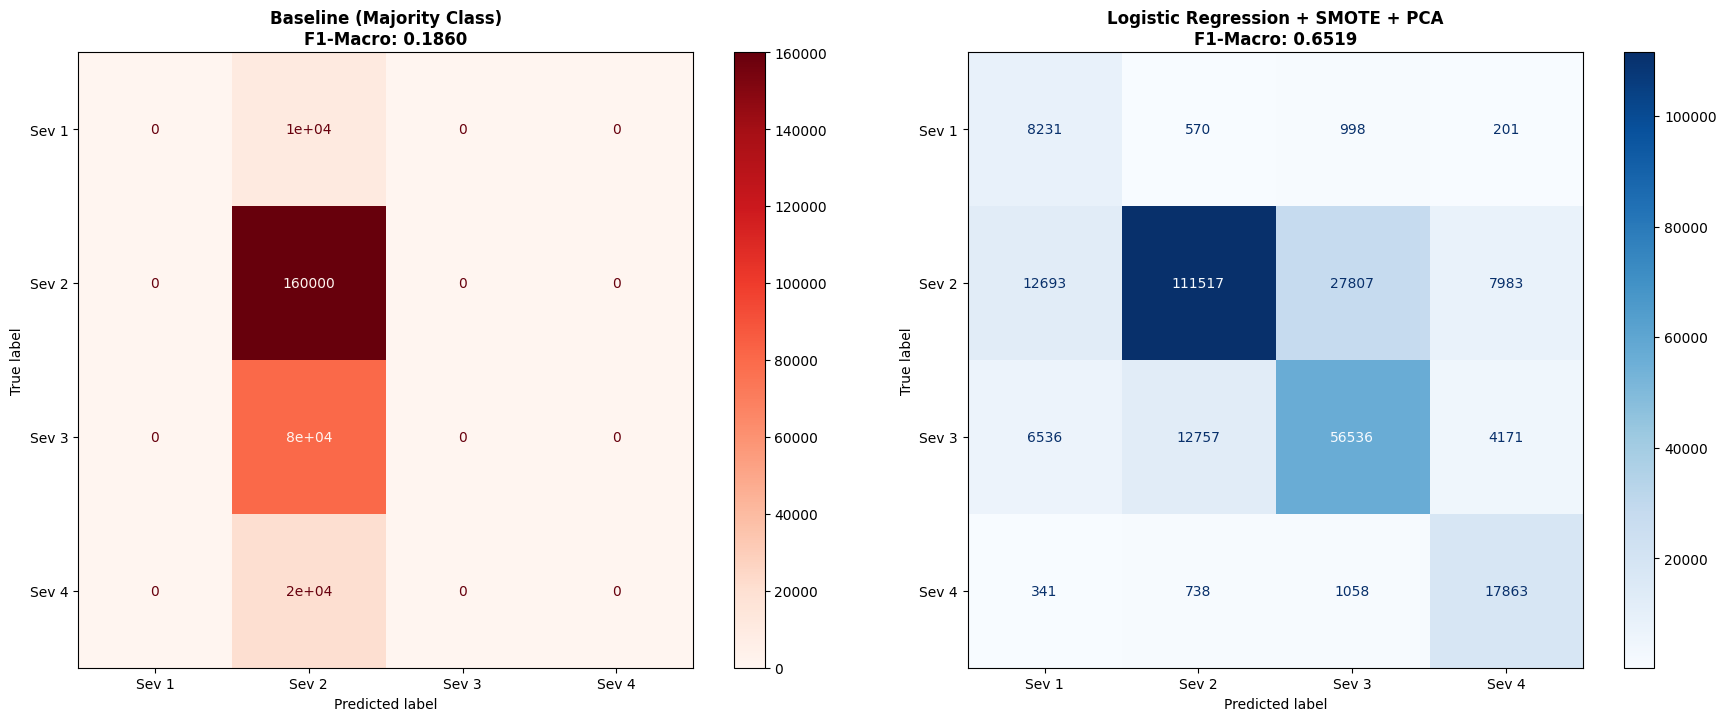

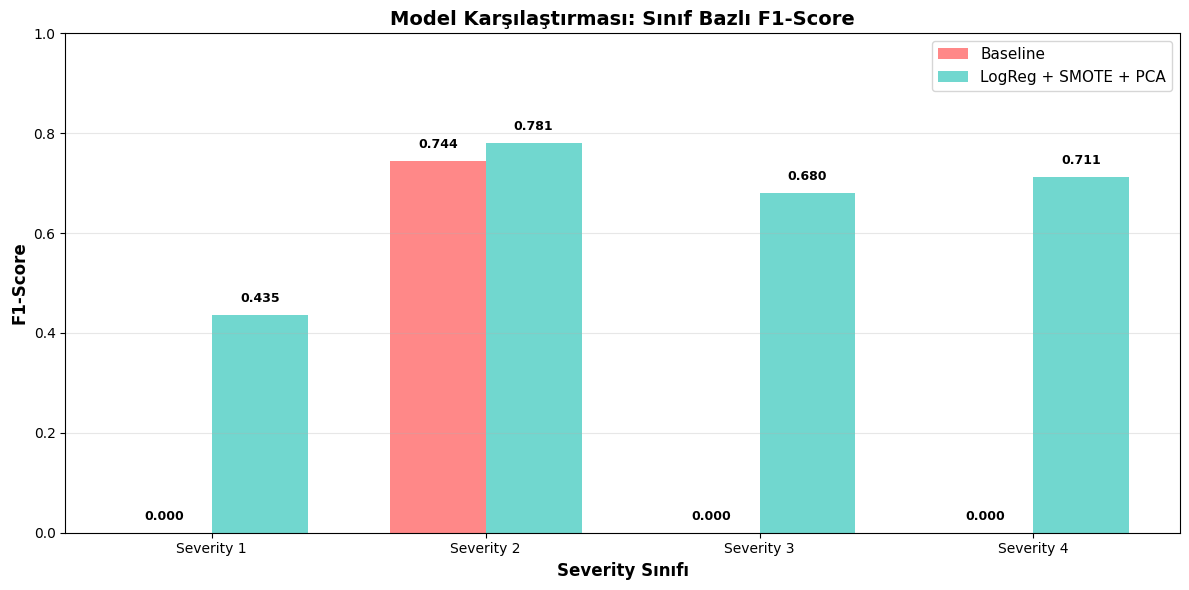


############################################################
### BÖLÜM 12: DETAYLI HATA ANALİZİ ###
############################################################

📊 DETAYLI SINIF BAZLI METRJKLER:

Severity 1:
   Precision: 0.2961
   Recall: 0.8231
   F1-Score: 0.4355

Severity 2:
   Precision: 0.8880
   Recall: 0.6970
   F1-Score: 0.7810

Severity 3:
   Precision: 0.6544
   Recall: 0.7067
   F1-Score: 0.6795

Severity 4:
   Precision: 0.5911
   Recall: 0.8931
   F1-Score: 0.7114



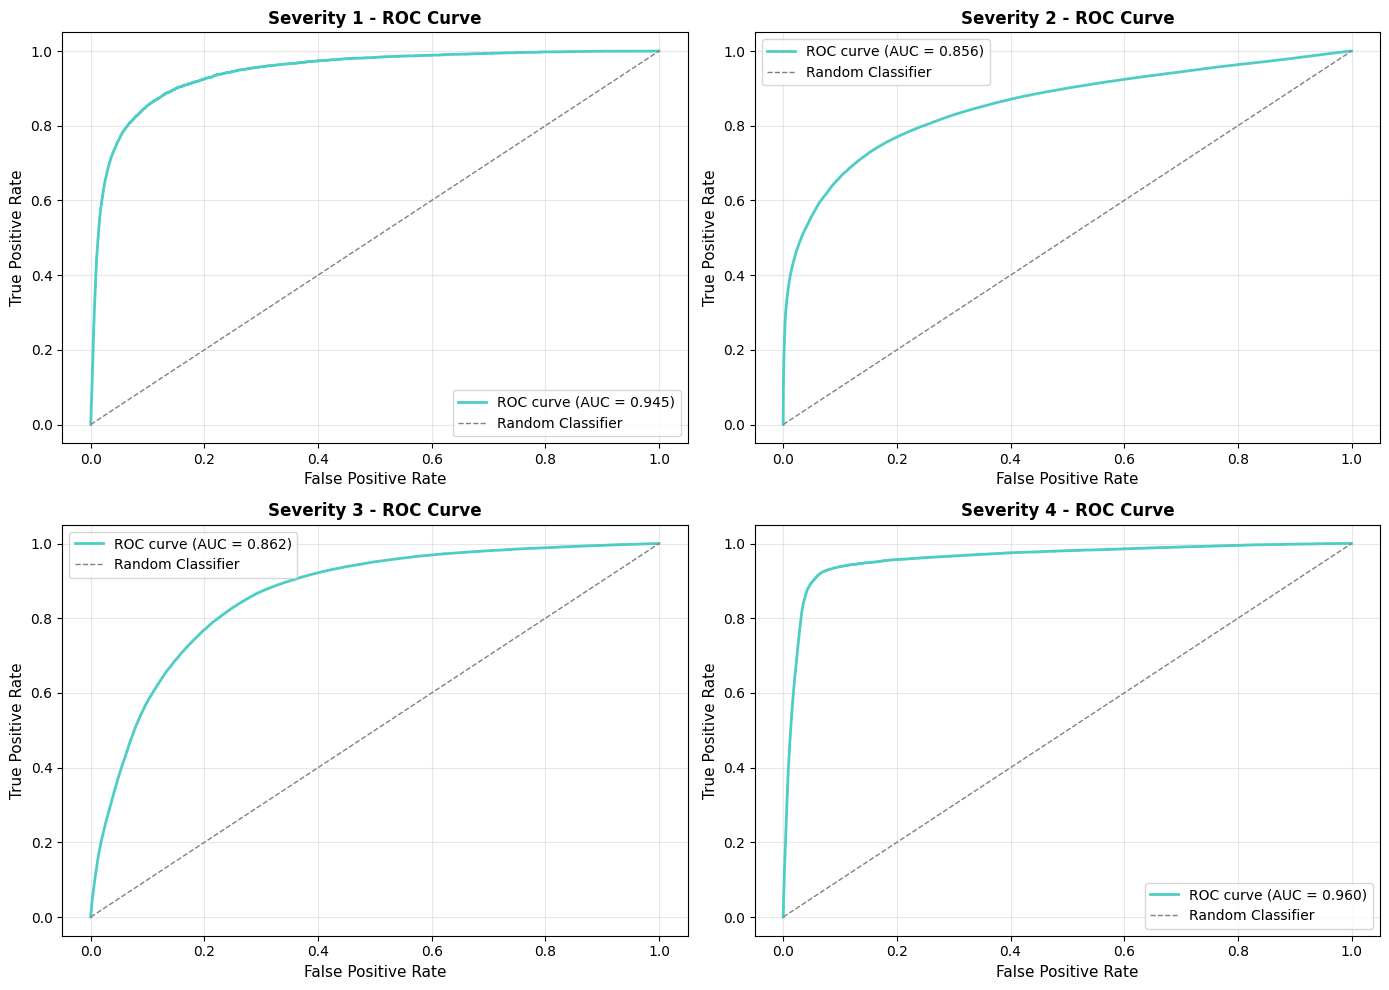


############################################################
### BÖLÜM 13: PCA ANALİZİ ###
############################################################

📊 PCA İstatistikleri:
   - Orijinal özellik sayısı: 108
   - PCA sonrası bileşen sayısı: 90
   - Açıklanan toplam varyans: %95.33
   - Boyut indirgeme oranı: %16.67


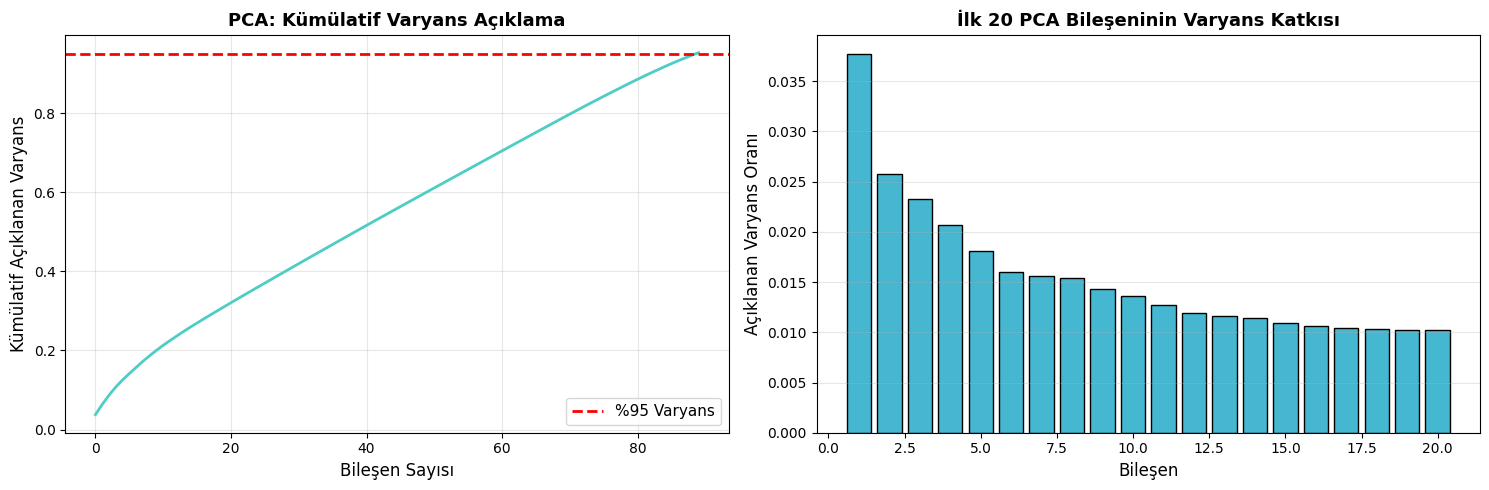



### 🎉 FİNAL ÖZET RAPORU 🎉 ###

📊 VERİ SETİ BOYUTU:
   - Toplam Örneklem: 1,350,000
   - Eğitim Seti: 1,080,000
   - Test Seti: 270,000
   - Orijinal Özellik Sayısı: 108
   - PCA Sonrası Bileşen: 90

🏆 BAŞARILI MODEL: Logistic Regression + SMOTE + PCA
   - Test F1-Macro Score: 0.6519
   - CV F1-Macro Score: 0.6525
   - Baseline Karşılaştırması: 250.37% iyileşme
   - Eğitim Süresi: 714.73 saniye

📊 SINIF BAZLI F1-SCORE:
   Severity 1: 0.4355
   Severity 2: 0.7810
   Severity 3: 0.6795
   Severity 4: 0.7114

⚙️  EN İYİ HİPERPARAMETRELER:
   clf__C: 1
   clf__solver: lbfgs
   pca__n_components: 0.95

### ✅ TAMAMLANDI! ###


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay, 
                             f1_score, make_scorer, roc_auc_score, roc_curve, auc,
                             precision_recall_curve, average_precision_score)
import time

# ======================================================================================
# --- BÖLÜM 0: VERİ YÜKLEME ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 0: VERİ YÜKLEME ###")
print("############################################################\n")

df = pd.read_csv('US_Accidents_March23.csv') 
print(f"Veri Seti Boyutu: {df.shape}")

print("\n--- Orijinal Sınıf Dağılımı ---")
print(df['Severity'].value_counts())
print("\n--- Yüzdesel Dağılım ---")
print(df['Severity'].value_counts(normalize=True))
print("\n\n")


# ======================================================================================
# --- BÖLÜM 1: STRATİFİED DENGELİ ÖRNEKLEME ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 1: DENGELİ ÖRNEKLEME STRATEJİSİ ###")
print("############################################################\n")

print("--- Stratified Dengeli Örnekleme Uygulanıyor ---")

sample_sizes = {
    1: 50000,
    2: 800000,
    3: 400000,
    4: 100000
}

dfs = []
for severity, size in sample_sizes.items():
    df_class = df[df['Severity'] == severity]
    
    if len(df_class) < size:
        print(f"  Severity {severity}: {len(df_class)} örnek (hepsi alınıyor)")
        dfs.append(df_class)
    else:
        print(f"  Severity {severity}: {size} örnek (rastgele seçildi)")
        dfs.append(df_class.sample(n=size, random_state=42))

df_sample = pd.concat(dfs, ignore_index=True)
df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)

del df

print(f"\n--- Dengeli Örneklem Sonrası Toplam: {len(df_sample)} ---")
print(df_sample['Severity'].value_counts())
print("\n--- Yeni Yüzdesel Dağılım ---")
print(df_sample['Severity'].value_counts(normalize=True))

print("\n--- Veri, Eğitim ve Test Setlerine Bölünüyor ---")
X = df_sample.drop('Severity', axis=1)
y = df_sample['Severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nEğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")
print("\n\n")


# ======================================================================================
# --- BÖLÜM 2: ÖZELLİK YARATMA ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 2: ÖZELLİK YARATMA ###")
print("############################################################\n")

def feature_creation_pipeline(df_input):
    df = df_input.copy()
    
    print("... Zamansal özellikler oluşturuluyor...")
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')
    df['Hour'] = df['Start_Time'].dt.hour
    df['Month'] = df['Start_Time'].dt.month
    df['DayOfWeek'] = df['Start_Time'].dt.dayofweek
    df['Is_Weekend'] = (df['DayOfWeek'] >= 5).astype(int)
    df['Is_Rush_Hour'] = ((df['Is_Weekend'] == 0) & (df['Hour'].isin([7, 8, 9, 15, 16, 17, 18]))).astype(int)
    df['Duration(min)'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60
    df.loc[df['Duration(min)'] < 0, 'Duration(min)'] = 0

    print("... 'Street' sütunundan özellikler türetiliyor...")
    if 'Street' in df.columns:
        df['Street'].fillna('Unknown', inplace=True)
        highway_keywords = ['Hwy', 'Fwy', 'Pkwy', 'Expy', 'Blvd', 'Highway', 'Freeway', 'I-', 'US-']
        df['Is_Highway'] = df['Street'].apply(lambda x: 1 if any(kw in str(x) for kw in highway_keywords) else 0)
        low_speed_keywords = ['St', 'Dr', 'Ave', 'Rd', 'Ln', 'Ct', 'Pl']
        pattern = r'\b(' + '|'.join(low_speed_keywords) + r')\b'
        df['Is_Low_Speed_Zone'] = df['Street'].str.contains(pattern, case=False, na=False).astype(int)

    print("... 'Description' sütunundan metin özellikler...")
    if 'Description' in df.columns:
        desc_lower = df['Description'].str.lower().fillna('')
        df['FEAT_Is_Road_Closed'] = desc_lower.str.contains('closed|closure', na=False).astype(int)
        df['FEAT_Is_Lane_Blocked'] = desc_lower.str.contains('blocked|lane', na=False).astype(int)
        df['FEAT_Is_Slowdown'] = desc_lower.str.contains('traffic|slow|caution', na=False).astype(int)
        df['FEAT_Is_Crash'] = desc_lower.str.contains('crash', na=False).astype(int)
        
    return df

X_train_created = feature_creation_pipeline(X_train)
X_test_created = feature_creation_pipeline(X_test)
print(f"Boyut: {X_train_created.shape}\n\n")


# ======================================================================================
# --- BÖLÜM 3-5: TEMİZLEME VE SAYISALLAŞTIRMA ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 3-5: VERİ TEMİZLEME VE SAYISALLAŞTIRMA ###")
print("############################################################\n")

cols_to_drop = [
    'ID', 'Source', 'End_Lat', 'End_Lng', 'County', 'Zipcode', 'Country', 
    'Start_Time', 'End_Time', 'Timezone', 'Airport_Code', 
    'Street', 'Description',
    'Weather_Timestamp', 'Wind_Chill(F)', 'Precipitation(in)', 'Weather_Condition'
]
X_train_selected = X_train_created.drop(columns=cols_to_drop, errors='ignore')
X_test_selected = X_test_created.drop(columns=cols_to_drop, errors='ignore')

print("... Şehir bazlı sıcaklık doldurma...")
city_median_temps_map = X_train_selected.groupby('City')['Temperature(F)'].median()
X_train_imputed = X_train_selected.copy()
X_test_imputed = X_test_selected.copy()
X_train_imputed['Temperature(F)'].fillna(X_train_imputed['City'].map(city_median_temps_map), inplace=True)
X_test_imputed['Temperature(F)'].fillna(X_test_imputed['City'].map(city_median_temps_map), inplace=True)
X_train_imputed.drop(columns=['City'], inplace=True)
X_test_imputed.drop(columns=['City'], inplace=True)

print("... Aykırı değer temizleme...")
cols_to_clip = [col for col in ['Temperature(F)', 'Wind_Speed(mph)', 'Distance(mi)', 'Duration(min)', 'Pressure(in)', 'Humidity(%)', 'Visibility(mi)'] if col in X_train_imputed.columns]
for col in cols_to_clip:
    lower, upper = X_train_imputed[col].quantile(0.01), X_train_imputed[col].quantile(0.99)
    X_train_imputed[col] = X_train_imputed[col].clip(lower=lower, upper=upper)
    X_test_imputed[col] = X_test_imputed[col].clip(lower=lower, upper=upper)

print("... Kalan eksik veriler dolduruluyor...")
fill_values = {col: (X_train_imputed[col].median() if pd.api.types.is_numeric_dtype(X_train_imputed[col]) else X_train_imputed[col].mode()[0]) for col in X_train_imputed.columns if X_train_imputed[col].isnull().sum() > 0}
X_train_imputed.fillna(value=fill_values, inplace=True)
X_test_imputed.fillna(value=fill_values, inplace=True)

print("... Boolean ve kategorik sütunlar sayısallaştırılıyor...")
bool_cols = X_train_imputed.select_dtypes(include='bool').columns
X_train_imputed[bool_cols] = X_train_imputed[bool_cols].astype(int)
X_test_imputed[bool_cols] = X_test_imputed[bool_cols].astype(int)

categorical_cols = X_train_imputed.select_dtypes(include='object').columns.tolist()
if len(categorical_cols) > 0:
    X_train_final = pd.get_dummies(X_train_imputed, columns=categorical_cols, drop_first=True)
    X_test_final = pd.get_dummies(X_test_imputed, columns=categorical_cols, drop_first=True)
    
    missing_in_test = set(X_train_final.columns) - set(X_test_final.columns)
    for c in missing_in_test: 
        X_test_final[c] = 0
    X_test_final = X_test_final[X_train_final.columns]
else:
    X_train_final = X_train_imputed.copy()
    X_test_final = X_test_imputed.copy()

print(f"Final boyut: {X_train_final.shape}\n\n")


# ======================================================================================
# --- BÖLÜM 6: HEDEF DEĞİŞKEN ---
# ======================================================================================
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1


# ======================================================================================
# --- BÖLÜM 7: BASELINE MODEL (DUMMY CLASSIFIER) ---
# ======================================================================================
print("############################################################")
print("### BÖLÜM 7: BASELINE MODEL (MAJORITY CLASS) ###")
print("############################################################\n")

print("🔥 Baseline Model: Majority Class Classifier\n")

dummy_model = DummyClassifier(strategy='most_frequent', random_state=42) #
dummy_model.fit(X_train_final, y_train_adjusted)
y_pred_baseline = dummy_model.predict(X_test_final)

baseline_f1_macro = f1_score(y_test_adjusted, y_pred_baseline, average='macro')
baseline_f1_per_class = f1_score(y_test_adjusted, y_pred_baseline, average=None)

print(f"✅ Baseline F1-Macro: {baseline_f1_macro:.4f}")
print(f"\n📊 BASELINE SINIF BAZLI F1-SCORE:")
severity_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
for name, score in zip(severity_names, baseline_f1_per_class):
    print(f"   {name}: {score:.4f}")


# ======================================================================================
# --- BÖLÜM 8: LOGISTIC REGRESSION + SMOTE + PCA PİPELINE ---
# ======================================================================================
print("\n############################################################")
print("### BÖLÜM 8: LOGISTIC REGRESSION + SMOTE + PCA PİPELINE ###")
print("############################################################\n")

print("🔥 Sadece Logistic Regression kullanılacak")
print("⚡ SMOTE ile azınlık sınıfları dengelenecek")
print("📊 PCA ile boyut indirgeme yapılacak\n")

pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=42)),
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('clf', LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1))
])

param_grid = {
    'pca__n_components': [0.95],
    'clf__C': [1],
    'clf__solver': ['lbfgs']
}

print(f"Toplam test edilecek kombinasyon: {np.prod([len(v) for v in param_grid.values()])}\n")

f1_scorer = make_scorer(f1_score, average='macro')

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=2,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=2
)

print("🚀 GridSearchCV başlıyor...\n")
start_time = time.time()
grid_search.fit(X_train_final, y_train_adjusted)
end_time = time.time()

print(f"\n✅ Eğitim tamamlandı!")
print(f"⏱️  Toplam süre: {end_time - start_time:.2f} saniye")


# ======================================================================================
# --- BÖLÜM 9: TEST SETİ DEĞERLENDİRMESİ ---
# ======================================================================================
print("\n############################################################")
print("### BÖLÜM 9: TEST SETİ DEĞERLENDİRMESİ ###")
print("############################################################\n")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_final)
y_pred_proba = best_model.predict_proba(X_test_final)

test_f1_macro = f1_score(y_test_adjusted, y_pred, average='macro')
test_f1_per_class = f1_score(y_test_adjusted, y_pred, average=None)

print(f"🎯 En İyi CV F1-Macro Score: {grid_search.best_score_:.4f}")
print(f"🎯 Test F1-Macro Score: {test_f1_macro:.4f}")
print(f"\n⚙️  En İyi Hiperparametreler:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📊 SINIF BAZLI F1-SCORE:")
for name, score in zip(severity_names, test_f1_per_class):
    print(f"   {name}: {score:.4f}")


# ======================================================================================
# --- BÖLÜM 10: MODEL KARŞILAŞTIRMASI (BASELINE vs ACTUAL) ---
# ======================================================================================
print("\n############################################################")
print("### BÖLÜM 10: MODEL KARŞILAŞTIRMASI ###")
print("############################################################\n")

# Karşılaştırma tablosu
comparison_data = {
    'Model': ['Baseline (Majority)', 'Logistic Regression + SMOTE + PCA'],
    'F1-Macro': [baseline_f1_macro, test_f1_macro],
    'Sev 1': [baseline_f1_per_class[0], test_f1_per_class[0]],
    'Sev 2': [baseline_f1_per_class[1], test_f1_per_class[1]],
    'Sev 3': [baseline_f1_per_class[2], test_f1_per_class[2]],
    'Sev 4': [baseline_f1_per_class[3], test_f1_per_class[3]]
}
comparison_df = pd.DataFrame(comparison_data)

print("📊 MODEL PERFORMANS KARŞILAŞTIRMASI:")
print(comparison_df.to_string(index=False))
print(f"\n✅ İyileşme (F1-Macro): {((test_f1_macro - baseline_f1_macro) / baseline_f1_macro * 100):.2f}%")


# ======================================================================================
# --- BÖLÜM 11: DETAYLI RAPOR VE GÖRSELLEŞTİRME ---
# ======================================================================================
print("\n\n############################################################")
print("### BÖLÜM 11: DETAYLI RAPOR VE GÖRSELLEŞTİRME ###")
print("############################################################\n")

print("--- Classification Report (Logistic Regression + SMOTE + PCA) ---")
print(classification_report(y_test_adjusted, y_pred, target_names=severity_names))

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Baseline CM
cm_baseline = confusion_matrix(y_test_adjusted, y_pred_baseline)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4'])
disp1.plot(cmap=plt.cm.Reds, ax=axes[0])
axes[0].set_title(f'Baseline (Majority Class)\nF1-Macro: {baseline_f1_macro:.4f}', fontsize=12, fontweight='bold')

# Actual CM
cm = confusion_matrix(y_test_adjusted, y_pred)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4'])
disp2.plot(cmap=plt.cm.Blues, ax=axes[1])
axes[1].set_title(f'Logistic Regression + SMOTE + PCA\nF1-Macro: {test_f1_macro:.4f}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Sınıf bazlı F1-Score grafiği
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(severity_names))
width = 0.35

bars1 = ax.bar(x - width/2, baseline_f1_per_class, width, label='Baseline', alpha=0.8, color='#FF6B6B')
bars2 = ax.bar(x + width/2, test_f1_per_class, width, label='LogReg + SMOTE + PCA', alpha=0.8, color='#4ECDC4')

ax.set_xlabel('Severity Sınıfı', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Model Karşılaştırması: Sınıf Bazlı F1-Score', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(severity_names)
ax.legend(fontsize=11)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Her bar üzerine değer yaz
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()


# ======================================================================================
# --- BÖLÜM 12: DETAYLI HATA ANALİZİ (PER-CLASS METRICS) ---
# ======================================================================================
print("\n############################################################")
print("### BÖLÜM 12: DETAYLI HATA ANALİZİ ###")
print("############################################################\n")

from sklearn.metrics import precision_score, recall_score

print("📊 DETAYLI SINIF BAZLI METRJKLER:\n")

for i, name in enumerate(severity_names):
    # One-vs-Rest yaklaşımı
    y_test_binary = (y_test_adjusted == i).astype(int)
    y_pred_binary = (y_pred == i).astype(int)
    
    precision = precision_score(y_test_binary, y_pred_binary, zero_division=0)
    recall = recall_score(y_test_binary, y_pred_binary, zero_division=0)
    f1 = f1_score(y_test_binary, y_pred_binary, zero_division=0)
    
    print(f"{name}:")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print()

# ROC-AUC grafiği (One-vs-Rest)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, name in enumerate(severity_names):
    y_test_binary = (y_test_adjusted == i).astype(int)
    
    # OvR için probability
    y_score = y_pred_proba[:, i]
    
    fpr, tpr, _ = roc_curve(y_test_binary, y_score)
    roc_auc = auc(fpr, tpr)
    
    axes[i].plot(fpr, tpr, color='#4ECDC4', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[i].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
    axes[i].set_xlabel('False Positive Rate', fontsize=11)
    axes[i].set_ylabel('True Positive Rate', fontsize=11)
    axes[i].set_title(f'{name} - ROC Curve', fontsize=12, fontweight='bold')
    axes[i].legend(fontsize=10)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# ======================================================================================
# --- BÖLÜM 13: PCA ANALİZİ ---
# ======================================================================================
print("\n############################################################")
print("### BÖLÜM 13: PCA ANALİZİ ###")
print("############################################################\n")

pca_component = best_model.named_steps['pca']

print(f"📊 PCA İstatistikleri:")
print(f"   - Orijinal özellik sayısı: {X_train_final.shape[1]}")
print(f"   - PCA sonrası bileşen sayısı: {pca_component.n_components_}")
print(f"   - Açıklanan toplam varyans: %{pca_component.explained_variance_ratio_.sum()*100:.2f}")
print(f"   - Boyut indirgeme oranı: %{(1 - pca_component.n_components_/X_train_final.shape[1])*100:.2f}")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(np.cumsum(pca_component.explained_variance_ratio_), linewidth=2, color='#4ECDC4')
axes[0].set_xlabel('Bileşen Sayısı', fontsize=12)
axes[0].set_ylabel('Kümülatif Açıklanan Varyans', fontsize=12)
axes[0].set_title('PCA: Kümülatif Varyans Açıklama', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='%95 Varyans')
axes[0].legend(fontsize=11)

n_show = min(20, len(pca_component.explained_variance_ratio_))
axes[1].bar(range(1, n_show+1), pca_component.explained_variance_ratio_[:n_show], 
            color='#45B7D1', edgecolor='black', linewidth=1)
axes[1].set_xlabel('Bileşen', fontsize=12)
axes[1].set_ylabel('Açıklanan Varyans Oranı', fontsize=12)
axes[1].set_title(f'İlk {n_show} PCA Bileşeninin Varyans Katkısı', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


# ======================================================================================
# --- FİNAL ÖZET RAPORU ---
# ======================================================================================
print("\n\n" + "="*100)
print("### 🎉 FİNAL ÖZET RAPORU 🎉 ###")
print("="*100)

print(f"\n📊 VERİ SETİ BOYUTU:")
print(f"   - Toplam Örneklem: {len(df_sample):,}")
print(f"   - Eğitim Seti: {len(X_train):,}")
print(f"   - Test Seti: {len(X_test):,}")
print(f"   - Orijinal Özellik Sayısı: {X_train_final.shape[1]}")
print(f"   - PCA Sonrası Bileşen: {pca_component.n_components_}")

print(f"\n🏆 BAŞARILI MODEL: Logistic Regression + SMOTE + PCA")
print(f"   - Test F1-Macro Score: {test_f1_macro:.4f}")
print(f"   - CV F1-Macro Score: {grid_search.best_score_:.4f}")
print(f"   - Baseline Karşılaştırması: {((test_f1_macro - baseline_f1_macro) / baseline_f1_macro * 100):.2f}% iyileşme")
print(f"   - Eğitim Süresi: {end_time - start_time:.2f} saniye")

print(f"\n📊 SINIF BAZLI F1-SCORE:")
for name, score in zip(severity_names, test_f1_per_class):
    print(f"   {name}: {score:.4f}")

print(f"\n⚙️  EN İYİ HİPERPARAMETRELER:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print("\n" + "="*100)
print("### ✅ TAMAMLANDI! ###")
print("="*100)